**Solveur for the steady-state solution of thermal diffusion under the action of a gaussian-distributed heat source moving at a constant velocity**

[*Pierre Kerfriden*]( https://tinyurl.com/mw4h5t7s), Mines Paris - PSL



**Links**:



1.   [Lecture notes](https://1drv.ms/b/s!AjM6vw3llOZ-j7gvbdwned3cRHL1rw?e=LvMO94)
2.   [PINNs notebook](https://colab.research.google.com/drive/1IJsIHkaoskWFNFnoPYiMTbTx0cos-tNR)

Licence for the notebook : [GNU GPL V3](https://www.gnu.org/licenses/gpl-3.0.en.html)

#Introduction

The thermal equilibrium equaition in a moving reference frame reads

$w \cdot \underline{\nabla u} - k \Delta u = f$

where $\underline{w} = - W \underline{e}_x$ is the velocity of the moving heat source.

Advection is assumed to take place in the form
$-k \underline{\nabla u} = \gamma (u-u_0)$ everywhere on the domain boundary.

The Gaussian-distributed heat source takes the form

$f(x) = \frac{P}{ \sqrt{ \displaystyle (2  \pi)^3 \xi} } \exp\left( \displaystyle - \frac{1}{\sigma^2} (x^2+y^2+(z/\epsilon)^2) \right)$

width $\xi = \sigma^6 \epsilon^2$

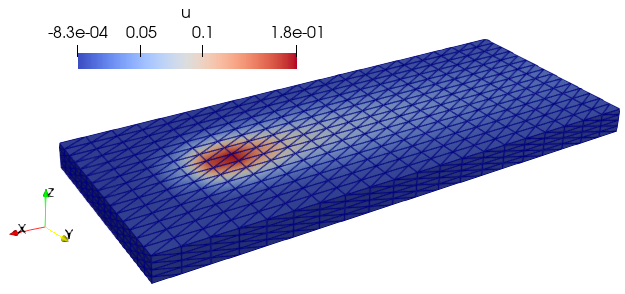

Notes:

Polynomial regression does great on max temperature, not so good on depth of melt pool, where NNeigh and GP perform better, espacially at low data count

Make an exercise to choose the polynomial order and number of datapoints, jointly, using early stopping.

Use UQ to find regions of space that have non zero melting

illustrat NNeigh in nons standardised input space. Does random stuff

# Environment setup

## Install FEniCSX via FEM on collab

 https://fem-on-colab.github.io/packages.html

 Will not be done when running these cells a second time, unless the session is restarted (avoid unless necessary)

In [97]:
import os
arch = os.getenv("ARGS", "real")

In [98]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl
    import dolfinx
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        if arch != "complex":
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        else:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        import ufl
        import dolfinx

In [99]:
import numpy as np
import petsc4py
import petsc4py.PETSc
if arch != "complex":
    assert not np.issubdtype(petsc4py.PETSc.ScalarType, np.complexfloating)
else:
    assert np.issubdtype(petsc4py.PETSc.ScalarType, np.complexfloating)

## Install Pyvista (Python library for VTK)

In [100]:
try:
  import pyvista
except ImportError:
  !apt-get update
  !apt-get install -qq xvfb libgl1-mesa-glx
  !pip install pyvista -qq

## Other imports

In [101]:
import time
import numpy as np
import matplotlib.pyplot as plt
import dolfinx
import pyvista
import sklearn

## Reference parameter values




In [102]:
parameters = {
    # heat source
    'heat_source_velocity': 30. ,
    'width_gaussian': 0.2 ,
    'ratio_width_z': 0.1 ,
    'power': 1.0 ,

    # material
    'advection_coeff': 1. ,
    'conductivity_coeff': 1. ,
    'melting_temperature': 0.08 ,

    # geometry
    'thickness': 0.25 ,
    'width': 2. ,
    'length': 2. ,

    'nb_elements': [20,15,6]
}
parameters_init = parameters.copy() # save dictionary to reset it later on after it has been modified by sampling processes

# **Finite element solver**

##Definition of FE solver class

In [103]:
from mpi4py import MPI
from dolfinx import mesh
from dolfinx import fem
from dolfinx import io
import ufl
from dolfinx.fem.petsc import LinearProblem

class heat_solver:

    def __init__(self,parameters):
        print("Initiating FEA solver")
        self.parameters = parameters

    def build_mesh(self):
        print("Meshing")
        length = self.parameters['length']
        width = self.parameters['width']
        thickness = self.parameters['thickness']
        nb_elements = self.parameters['nb_elements']
        self.domain = mesh.create_box(MPI.COMM_WORLD,
            [[-length/2-3*length/2,-width/2.,-thickness],
            [length/2.,width/2.,0]],
            nb_elements, mesh.CellType.tetrahedron)

    def export_mesh_vtk(self):
        print("Exporting mesh in VTK")
        filename="out/mesh.xdmf"
        with dolfinx.io.XDMFFile(MPI.COMM_WORLD, filename, "w") as file:
            file.write_mesh(self.domain)

    def export_solution_vtk(self):
        print("Exporting solution in VTK")
        filename="out/solution.xdmf"
        with dolfinx.io.XDMFFile(MPI.COMM_WORLD, filename, "w") as file:
            file.write_mesh(self.domain)
            file.write_function(self.uh)

    def convert_2_pyvista(self):
        #print("Converting to pyvista")
        points = self.domain.geometry.x
        cells = self.domain.geometry.dofmap
        n_cells = self.domain.geometry.dofmap.shape[0]
        vector_filled_with_4 = np.full(n_cells, 4)
        cells = np.hstack((vector_filled_with_4.reshape(-1,1),cells))
        celltypes = np.full(n_cells, fill_value=pyvista.CellType.TETRA, dtype=np.uint8)
        grid = pyvista.UnstructuredGrid(cells, celltypes, points)
        grid.point_data["uh"] = self.uh.x.array
        return grid

    def plot_solution_pyvista(self): # https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html
        pyvista.set_jupyter_backend('static')
        pyvista.global_theme.notebook = True
        pyvista.start_xvfb()

        grid = self.convert_2_pyvista()
        grid.plot(show_edges=True)

    def heat_source(self,x):
        width_gaussian = self.parameters['width_gaussian']
        ratio_width_z = self.parameters['ratio_width_z']
        power = self.parameters['power']

        det = width_gaussian**6*ratio_width_z**2
        integral = np.sqrt( (2.*np.pi)**3 * det )
        return power/integral * np.exp( - 1/(2.)*( (x[0]/width_gaussian)**2 + (x[1]/width_gaussian)**2+(x[2]/(width_gaussian*ratio_width_z))**2))

    def extract_max(self):
        return np.max(self.uh.x.array)

    def extract_melt_pool(self,plot=False):
        melting_temperature = self.parameters['melting_temperature']

        if plot==True:
            pyvista.set_jupyter_backend('static')
            pyvista.global_theme.notebook = True
            pyvista.start_xvfb()

        grid = self.convert_2_pyvista()
        contours = grid.contour(np.asarray([melting_temperature]))

        if plot==True and len(contours.points)>0:
            #contours.plot()
            pl = pyvista.Plotter()
            #pl.add_mesh(mesh.outline(), color="k")
            pl.add_mesh(grid, opacity=0.2)
            pl.add_mesh(contours,show_edges=True)
            #pl.camera_position = [
            #  (-130.99381142132086, 644.4868354828589, 163.80447435848686),
            #  (125.21748748157661, 123.94368717158413, 108.83283586619626),
            #  (0.2780372840777734, 0.03547871361794171, 0.9599148553609699),
            #]
            pl.show()

        return contours

    def extract_melt_pool_depth(self):
        contours = self.extract_melt_pool()
        if len(contours.points)>0:
            return np.abs( min(contours.points[:,2]) )
        else:
            return 0

    def extract_melt_pool_width(self):
        contours = self.extract_melt_pool()
        if len(contours.points)>0:
            return max(contours.points[:,1]) - min(contours.points[:,1])
        else:
            return 0

    def extract_temperature_at_points(self,points,plot=False):

        grid = self.convert_2_pyvista()
        point_cloud = pyvista.PolyData(points)
        sampled_data = point_cloud.interpolate(grid)

        if plot==True:
            pyvista.set_jupyter_backend('static')
            pyvista.global_theme.notebook = True
            pyvista.start_xvfb()

            pl = pyvista.Plotter()
            pl.add_mesh(grid, opacity=0.2)
            pl.add_mesh(point_cloud, color='black', point_size=10)
            pl.show()

        return sampled_data['uh']

    def solve(self):
        V = fem.functionspace(self.domain, ("CG", 1))

        f = fem.Function(V)
        f.interpolate(self.heat_source)

        heat_source_velocity = self.parameters['heat_source_velocity']
        vel = fem.Constant(self.domain, [-heat_source_velocity, 0.0, 0.0])

        u = ufl.TrialFunction(V)
        v = ufl.TestFunction(V)

        conductivity_coeff = self.parameters['conductivity_coeff']
        advection_coeff = self.parameters['advection_coeff']

        a = conductivity_coeff * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
        a += v * ufl.dot( ufl.grad(u) , vel) * ufl.dx
        a += advection_coeff * u * v * ufl.ds
        L = f * v * ufl.dx
        #a += u * v * ds(1)

        problem = LinearProblem(a, L, bcs=[], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        self.uh = problem.solve()
        self.uh.name = "u"

# def boundary_sides(x): # takes as input a gdimxN array, where N is the number of evaluation points. Need to output a boolean vector of N compnents
#   is_on_boundary = ( x[1]<= (-30. + 1.e-8) ) | ( x[1]>= (30. - 1.e-8) )
#   return is_on_boundary

# def boundary_bottom(x): # takes as input a gdimxN array, where N is the number of evaluation points. Need to output a boolean vector of N compnents
#   is_on_boundary = ( x[2]<= (-0.25 + 1.e-8) )
#   return is_on_boundary

# fdim = domain.topology.dim - 1
# facets = mesh.locate_entities_boundary(domain, fdim, boundary_bottom)
# facet_marker = np.ones_like(facets)
# facet_tag = mesh.meshtags(domain, fdim, facets, facet_marker)
# ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

# filename = "out/boundary_tags.xdmf"
# with dolfinx.io.XDMFFile(MPI.COMM_WORLD, filename, "w") as file:
#   file.write_mesh(domain)
#   file.write_meshtags(facet_tag,domain.geometry)

# import ufl
# ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

In [104]:
parameters = parameters_init.copy()
solver = heat_solver(parameters)
solver.build_mesh()

Initiating FEA solver
Meshing


## Test run for FEA

timing to solve 0.1316232681274414
Exporting solution in VTK


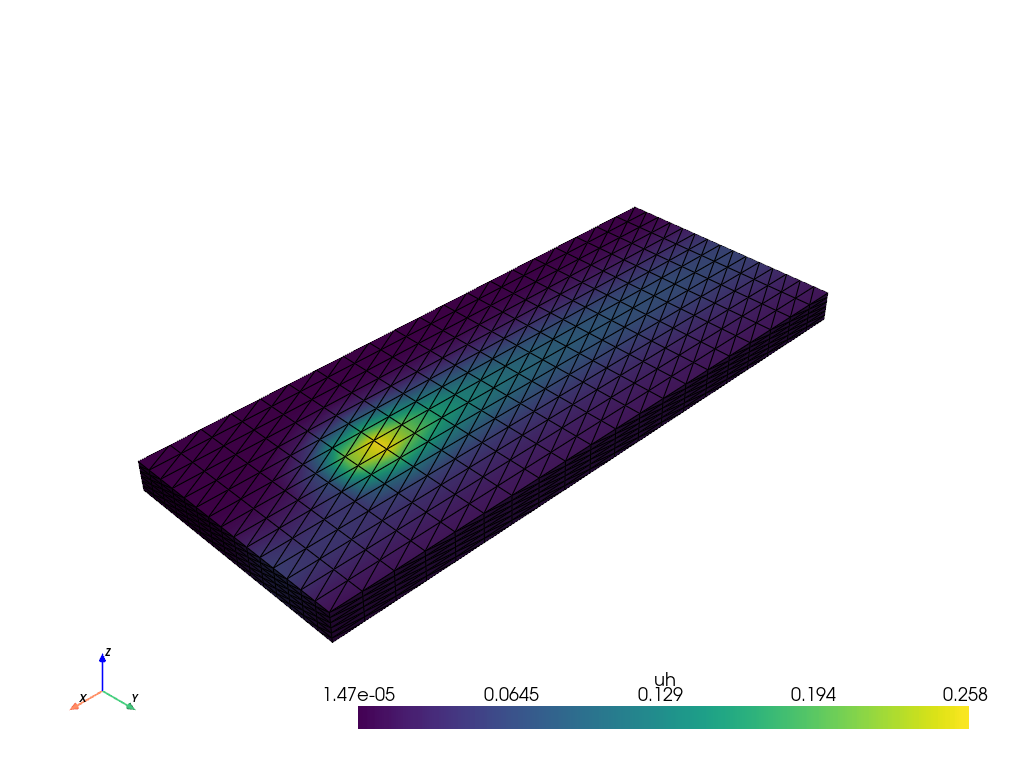

timing to display 3.5028493404388428


In [105]:
t = time.time()
parameters = parameters_init.copy()
parameters['power'] = 3.
parameters['heat_source_velocity'] = 100.
solver.parameters = parameters
solver.solve()
elapsed = time.time() - t
print("timing to solve",elapsed)

t = time.time()
solver.export_solution_vtk()
solver.plot_solution_pyvista()
elapsed = time.time() - t
print("timing to display",elapsed)

## Extract quantities of interest



1.   Maximum temperature
2.   Depth and width of melt pool (material above the melting temperature)
3.   Temperature at an array of user-defined thermal sensors



In [106]:
print('max temperature',solver.extract_max())

max temperature 0.25811965297646733


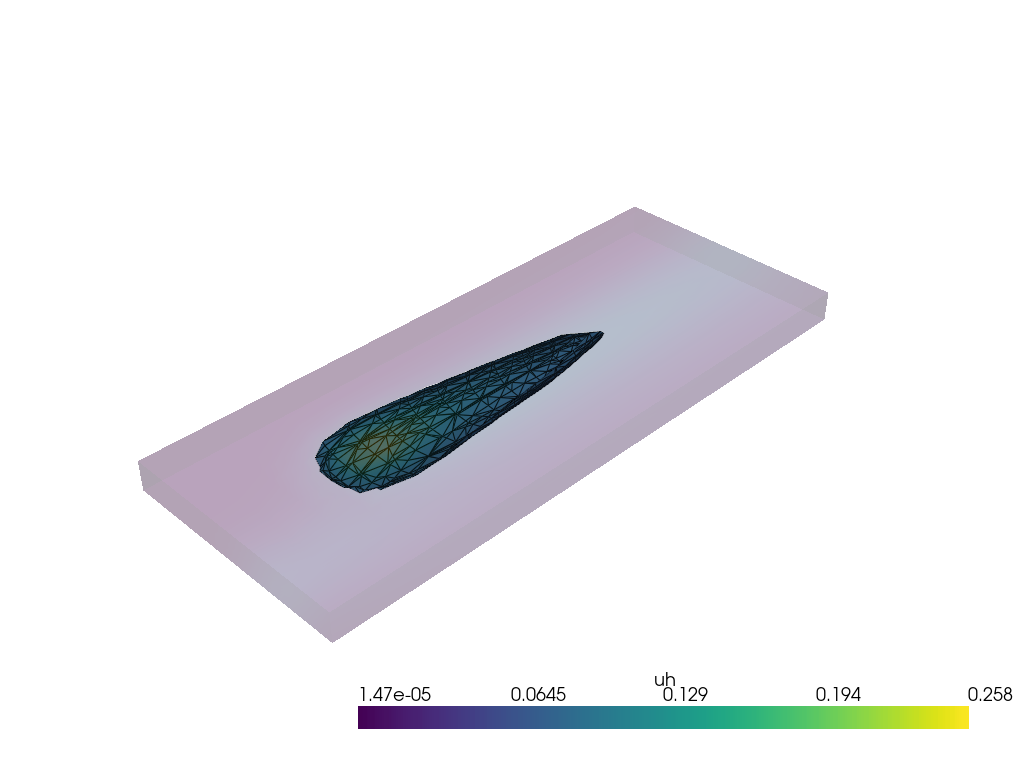

solver.extract_melt_pool_depth() 0.20337206839273375
solver.extract_melt_pool_width() 0.757866883277893


In [107]:
solver.extract_melt_pool(plot=True)
print('solver.extract_melt_pool_depth()',solver.extract_melt_pool_depth())
print('solver.extract_melt_pool_width()',solver.extract_melt_pool_width())

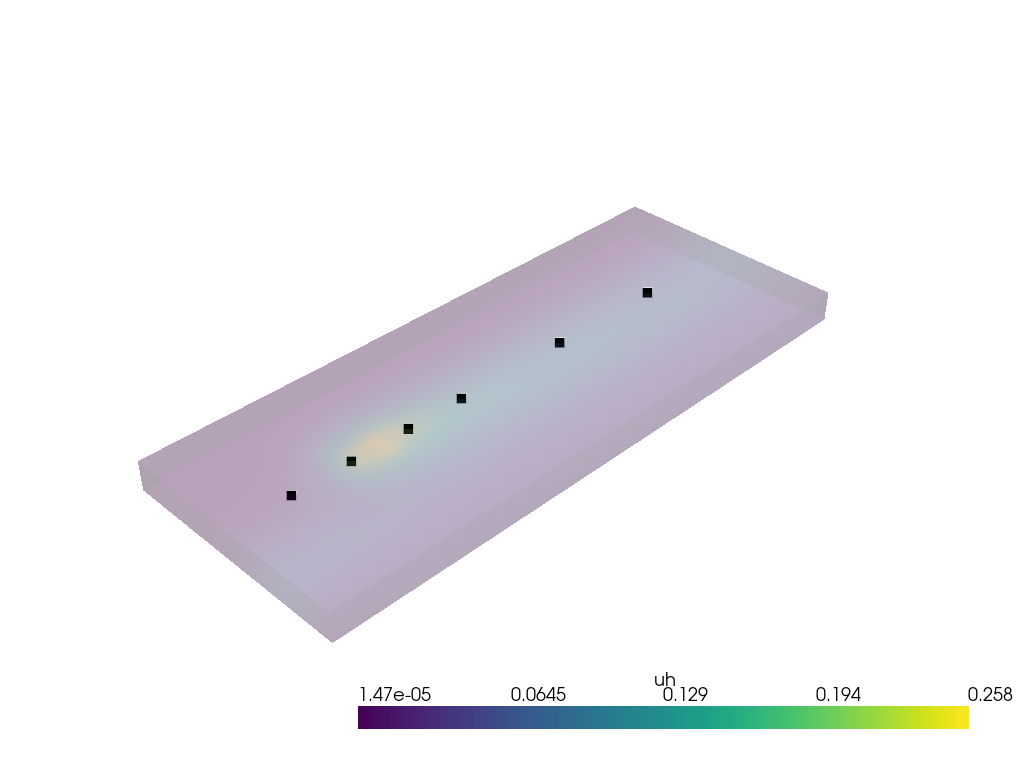

temperatures [0.0228186  0.04686608 0.06696688 0.06710472 0.05880961 0.05236282]


In [108]:
points = np.array([
    [0.5, 0., 0.],
    [0., 0., 0.],
    [-0.5, 0., 0.],
    [-1., 0., 0.],
    [-2., 0., 0.],
    [-3., 0., 0.],
])
temperatures = solver.extract_temperature_at_points(points,plot=True)
print("temperatures",temperatures)

##Definition of Quantities of interest

In [109]:
def compute_melt_pool_depth(params,solver):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    out = solver.extract_melt_pool_depth()
    return np.array(out).reshape((-1,))

def compute_max_temperature(params,solver):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    out = solver.extract_max()
    return np.array(out).reshape((-1,))

def compute_temperature_sensors(params,solver):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    points = np.array([
    [0.5, 0., 0.],
    [0., 0., 0.],
    [-0.5, 0., 0.],
    [-1., 0., 0.],
    [-2., 0., 0.],
    [-3., 0., 0.],
    ])
    out = solver.extract_temperature_at_points(points)
    return np.array(out).reshape((-1,))

#compute_QoI = lambda params: compute_max_temperature(params,solver)
#compute_QoI = lambda params: compute_melt_pool_depth(params,solver)
#compute_QoI = lambda params: compute_temperature_sensors(params,solver)
#plot_solution = lambda : plot_solution_FEA(solver)

# **Definition of sampler class**

## Plotting function

Function to plot meta-model predictions over regular grids in 1D and 2D

In [110]:
def prediction_plot(X=None,y=None,function=None,x_plot=None, y_plot=None,show=True,marker_color=True,clabel=None,xlabel=None,ylabel=None,xlim=None,ylim=None):

    if X is not None:
        dim = X.shape[1]
    elif y_plot is None and x_plot is not None:
        dim = 1
    elif y_plot is not None and x_plot is not None:
        dim = 2
    else:
        'cannot plot if data is not 1D or 2D'

    if dim>2:
        'cannot plot if data is not 1D or 2D'

    if x_plot is None:
        x_min = np.min(X[:,0])
        x_max = np.max(X[:,0])
        x_plot = np.linspace(x_min, x_max, 40)
    if dim==2 and (y_plot is None):
        y_min = np.min(X[:,1])
        y_max = np.max(X[:,1])
        y_plot = np.linspace(y_min, y_max, 40)

    if dim==2:

        X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

        if function is not None:
            X_grid = np.concatenate((X_plot.reshape((-1,1)),Y_plot.reshape((-1,1))),axis=1)
            Z = function(X_grid)
            Z = Z.reshape((len(y_plot),len(x_plot)))
            plt.contourf(X_plot, Y_plot, Z, 20, alpha=0.2)
            if clabel is not None:
                plt.colorbar(label=clabel)
            else:
                plt.colorbar()
            plt.contour(X_plot, Y_plot, Z, 20, colors='black')

        if X is not None:
            if (y is not None) and marker_color==True:
                plt.scatter(X[:,0],X[:,1],c=y)
                if clabel is not None:
                    plt.colorbar(label=clabel)
                else:
                    plt.colorbar()
            else:
                plt.scatter(X[:,0],X[:,1],c='k')

        if xlabel is not None:
            plt.xlabel(xlabel)

        if ylabel is not None:
            plt.ylabel(ylabel)

    elif dim==1:

        if function is not None:
            X_plot = x_plot.reshape((-1,1))
            Z = function(X_plot)

            plt.plot(x_plot,Z)

        if (y is not None):
            plt.scatter(X,y,c='k')

        if xlabel is not None:
            plt.xlabel(xlabel)

        if ylabel is not None:
            plt.ylabel(ylabel)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None and dim==2:
        plt.ylim(ylim)

    plt.grid()
    if show==True:
        plt.show()

def surf_plot(function=None,x_plot=None, y_plot=None,show=True,xlim=None,ylim=None,xlabel=None,ylabel=None,zlabel=None, X=None, Y=None):

    from matplotlib import cm

    X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

    X_grid = np.concatenate((X_plot.reshape((-1,1)),Y_plot.reshape((-1,1))),axis=1)
    Z = function(X_grid)
    Z = Z.reshape((len(y_plot),len(x_plot)))

    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_plot, Y_plot, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if zlabel is not None:
        ax.set_zlabel(zlabel)

    if X is not None:
        ax.scatter(X[:,0],X[:,1],Y.squeeze())

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    if show==True:
        plt.show()


##sampler class

### Sparse grid

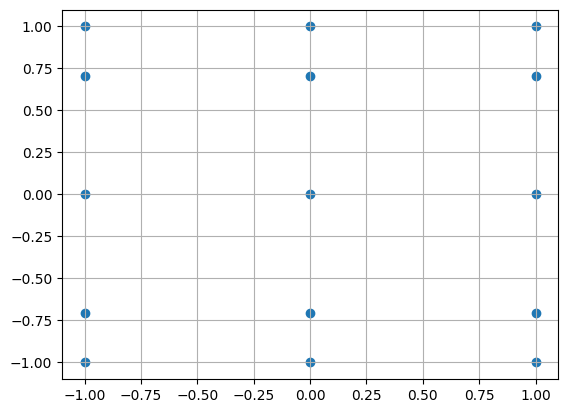

In [111]:
def clenshaw_curtis_compute ( n ):

#*****************************************************************************80
#
## CLENSHAW_CURTIS_COMPUTE computes a Clenshaw Curtis quadrature rule.
#
#  Discussion:
#
#    This method uses a direct approach.  The paper by Waldvogel
#    exhibits a more efficient approach using Fourier transforms.
#
#    The integral:
#
#      integral ( -1 <= x <= 1 ) f(x) dx
#
#    The quadrature rule:
#
#      sum ( 1 <= i <= n ) w(i) * f ( x(i) )
#
#    The abscissas for the rule of order N can be regarded
#    as the cosines of equally spaced angles between 180 and 0 degrees:
#
#      X(I) = cos ( ( N - I ) * PI / ( N - 1 ) )
#
#    except for the basic case N = 1, when
#
#      X(1) = 0.
#
#    A Clenshaw-Curtis rule that uses N points will integrate
#    exactly all polynomials of degrees 0 through N-1.  If N
#    is odd, then by symmetry the polynomial of degree N will
#    also be integrated exactly.
#
#    If the value of N is increased in a sensible way, then
#    the new set of abscissas will include the old ones.  One such
#    sequence would be N(K) = 2*K+1 for K = 0, 1, 2, ...
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    02 April 2015
#
#  Author:
#
#    John Burkardt
#
#  Reference:
#
#    Charles Clenshaw, Alan Curtis,
#    A Method for Numerical Integration on an Automatic Computer,
#    Numerische Mathematik,
#    Volume 2, Number 1, December 1960, pages 197-205.
#
#    Philip Davis, Philip Rabinowitz,
#    Methods of Numerical Integration,
#    Second Edition,
#    Dover, 2007,
#    ISBN: 0486453391,
#    LC: QA299.3.D28.
#
#    Joerg Waldvogel,
#    Fast Construction of the Fejer and Clenshaw-Curtis Quadrature Rules,
#    BIT Numerical Mathematics,
#    Volume 43, Number 1, 2003, pages 1-18.
#
#  Parameters:
#
#    Input, integer N, the order.
#
#    Output, real X(N), the abscissas.
#
#    Output, real W(N), the weights.
#
  import numpy as np

  if ( n == 1 ):

    x = np.zeros ( n )
    w = np.zeros ( n )

    w[0] = 2.0

  else:

    theta = np.zeros ( n )

    for i in range ( 0, n ):
      theta[i] = float ( n - 1 - i ) * np.pi / float ( n - 1 )

    x = np.cos ( theta )
    w = np.zeros ( n )

    for i in range ( 0, n ):

      w[i] = 1.0

      jhi = ( ( n - 1 ) // 2 )

      for j in range ( 0, jhi ):

        if ( 2 * ( j + 1 ) == ( n - 1 ) ):
          b = 1.0
        else:
          b = 2.0

        w[i] = w[i] - b * np.cos ( 2.0 * float ( j + 1 ) * theta[i] ) \
             / float ( 4 * j * ( j + 2 ) + 3 )

    w[0] = w[0] / float ( n - 1 )
    for i in range ( 1, n - 1 ):
      w[i] = 2.0 * w[i] / float ( n - 1 )
    w[n-1] = w[n-1] / float ( n - 1 )

  return x, w

x , _ = clenshaw_curtis_compute(3)
y , _ = clenshaw_curtis_compute(5)
points = np.array( np.meshgrid( x, y  ) ).T.reshape(-1, 2)
plt.scatter(points[:,0],points[:,1])
plt.grid()

In [112]:
def compute_n_from_level(l):
    if l==0:
        n=0
    elif l==1:
        n=1
    elif l==2:
        n=3
    else:
        n=3
        for i in range(l-2):
            n = n + (n-1)
    return n

def generate_delta_grid(N):
    list_delta_x = [ clenshaw_curtis_compute(1)[0].tolist() ]
    tolerance = 1.e-6
    for i in range(N-1):
        delta_x_prev , _ = clenshaw_curtis_compute(compute_n_from_level(i+1))
        delta_x , _ = clenshaw_curtis_compute(compute_n_from_level(i+2))
        mask = np.all(np.abs(delta_x[:, None] - delta_x_prev) > tolerance, axis=1)
        delta_x = delta_x[mask]
        list_delta_x.append(delta_x.tolist())
    return list_delta_x

#print(compute_n_from_level(3))
#print(compute_n_from_level(4))
print("generate_delta_grid(2))",generate_delta_grid(2))
print("generate_delta_grid(2))",generate_delta_grid(3))

generate_delta_grid(2)) [[0.0], [-1.0, 1.0]]
generate_delta_grid(2)) [[0.0], [-1.0, 1.0], [-0.7071067811865475, 0.7071067811865476]]


In [113]:
import itertools

def generate_multi_index(D, N):
    """
    Generate a multi-index for dimension D such that the sum of the indices is less than N.

    Args:
        D (int): The number of dimensions.
        N (int): The maximum sum of indices.

    Returns:
        list of tuples: A list of tuples representing the multi-index.
    """
    # Generate all possible combinations of indices in the range [0, N)
    ranges = [range(N+1) for _ in range(D)]

    # Filter combinations where the sum of indices is less than N
    multiindex = [index for index in itertools.product(*ranges) if sum(index) <= N]

    return multiindex

print("generate_multi_index(2, 3)",generate_multi_index(2, 3))

def meshgrid_from_list(vectors):
    """
    Generates an N-dimensional meshgrid from a list of vectors.

    Parameters:
        vectors (list of np.array): List of 1D arrays representing each dimension.

    Returns:
        A NumPy array of shape (num_points, N), where each row is an N-dimensional coordinate.
    """
    grids = np.meshgrid(*vectors, indexing='ij')  # Create meshgrid with matrix-style indexing
    grid_flat = [g.ravel() for g in grids]  # Flatten each dimension
    return np.vstack(grid_flat).T  # Stack and transpose

def generate_sparse_grid(dim,N):
    MI = generate_multi_index(dim, N-1)
    list_delta_x = generate_delta_grid(N)
    points = []
    for i in range(len(MI)):
        vectors = [list_delta_x[j] for j in MI[i]]
        points_i = meshgrid_from_list(vectors)
        points.append(points_i.tolist())
    points = [item for sublist in points for item in sublist]
    return np.array(points)

generate_multi_index(2, 3) [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (3, 0)]


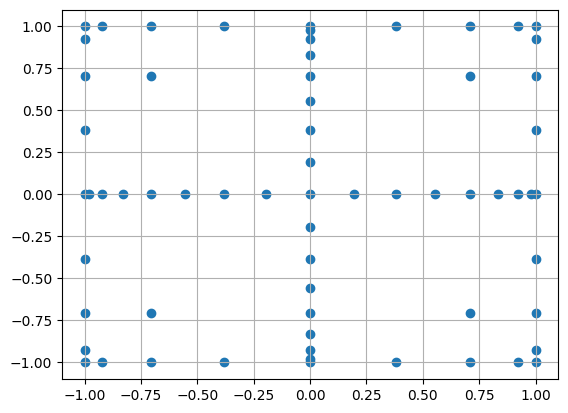

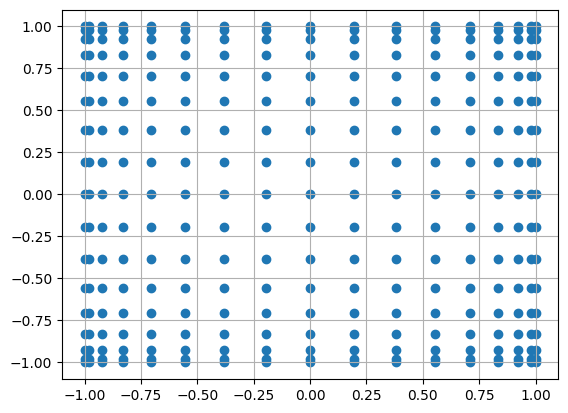

In [114]:
dim = 2
N = 5 # number of refinement levels in hierarchical grid
points = generate_sparse_grid(dim,N)

if dim==2:
    plt.scatter(points[:,0],points[:,1])
    plt.grid()
if dim==3:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0],points[:,1],points[:,2])
    filtered_arr = points[(points[:, 0] >= -0.01) & (points[:, 0] <= 0.01)]
    ax.scatter(filtered_arr[:,0],filtered_arr[:,1],filtered_arr[:,2],c='black', alpha=1)
    #plt.xlim(-0.01,0.01)
plt.show()

x , _ = clenshaw_curtis_compute(compute_n_from_level(5))
points = np.array( np.meshgrid( x, x ) ).T.reshape(-1, 2)
plt.scatter(points[:,0],points[:,1])
plt.grid()

In [115]:
from itertools import product

def generate_integers(i, j):
    return list(range(i, j ))

def generate_list_orders(N):
    list_orders = []
    for i in range(0,N):
        n1 = compute_n_from_level(i)
        n2 = compute_n_from_level(i+1)
        list_orders.append(generate_integers(n1,n2))
    return list_orders

def generate_combinations(list_orders, index_vectors):
    all_combinations = []

    for index_vector in index_vectors:
        selected_sublists = [list_orders[i] for i in index_vector]
        combinations = list(product(*selected_sublists))
        all_combinations.extend(product(*selected_sublists))
    return all_combinations  # List of lists of combinations

def generate_list_orders_dim(dim,N):
    list_orders = generate_list_orders(N)
    #print("list_orders",list_orders)
    MI = generate_multi_index(dim, N-1)
    #print("MI",MI)
    list_orders_dim = generate_combinations(list_orders, MI)
    return list_orders_dim

list_orders_dim = generate_list_orders_dim(dim,N)
print(list_orders_dim)
print("len(list_orders_dim)",len(list_orders_dim))

points = generate_sparse_grid(dim,N)
print("len(points)",len(points))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (1, 0), (2, 0), (1, 1), (1, 2), (2, 1), (2, 2), (1, 3), (1, 4), (2, 3), (2, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 5), (2, 6), (2, 7), (2, 8), (3, 0), (4, 0), (3, 1), (3, 2), (4, 1), (4, 2), (3, 3), (3, 4), (4, 3), (4, 4), (5, 0), (6, 0), (7, 0), (8, 0), (5, 1), (5, 2), (6, 1), (6, 2), (7, 1), (7, 2), (8, 1), (8, 2), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0)]
len(list_orders_dim) 65
len(points) 65


### DOE

DOE class for parameter space $[0 \ 1]^N$

In [116]:
class DOE_cls:

    def __init__(self,dim,DOE_type="PRS"):
        print("Instantiating ",DOE_type," sampler")

        self.dim = dim
        self.DOE_type = DOE_type
        self.X = None

        if self.DOE_type == "QRS":
            from scipy.stats import qmc
            sampler = qmc.Sobol(d=self.dim, scramble=False)
            samples = sampler.random_base2(m=20) # draw 2**m points
            print("samples.shape",samples.shape)
            self.X_all = samples


    def sample(self,N,as_additional_points=False):

        if  self.DOE_type == "PRS":

            X = np.random.rand(N,self.dim)

            if as_additional_points==True and (self.X is not None):
                print("adding as new")
                self.X = np.concatenate((self.X,X),axis=0)
            else:
                self.X = X

        elif self.DOE_type == "LHS":

            from scipy.stats import qmc
            sampler = qmc.LatinHypercube(d=self.dim)
            X = sampler.random(n=N)
            print("sample.shape",X.shape)

            if as_additional_points==True and (self.X is not None):
                print("adding as new")
                print("!!! adding as new in LHS may lead to undesirable behaviour")
                self.X = np.concatenate((self.X,X),axis=0)
            else:
                self.X = X

        elif self.DOE_type == "QRS":

            if as_additional_points==True and (self.X is not None):
                print("adding as new")
                len_prec = len(self.X)
                X = self.X_all[len_prec:(len_prec+N),:]
                self.X = self.X_all[:(len_prec+N),:]
            else:
                X = self.X_all[:N,:]
                self.X = X

        elif self.DOE_type == "SG":

            print("generating sparse grid of order",N,"in dimension",self.dim)

            X = 0.5*(generate_sparse_grid(self.dim,N) + 1.) # N is the number of refinement levels in hierarchical grid

            if as_additional_points==True and (self.X is not None):
                print("adding as new not fully checked for sparse grids") # otherwise would need to to a diff and check if it is non empty

                mask = np.isin(X.view([('', X.dtype)] * X.shape[1]), self.X.view([('', self.X.dtype)] * self.X.shape[1]))
                X = X[~mask.any(axis=1)] # points that are not already in self.X

                self.X = np.concatenate((self.X,X),axis=0)

            else:
                self.X = X

        return X

### FEA sampling interface

In [117]:
class sampler_cls:
    def __init__(self,types,params,dimensions=None,compute_QoIs=None,plot_solution=None,n_out=None):

        # dimensions : a list of parameter names to be sampled
        # type : list of distribution types, may be 'uniform', 'log uniform', 'normal' or 'log normal'
        # params : a list of bounds for parametric dimensions, or list of gaussian parameters if the distributions are gaussian of log normal

        print("Building your FEA sampler...")

        self.dimensions = dimensions
        self.params = params
        self.n_out = n_out
        self.compute_QoIs = compute_QoIs
        self.plot_solution = plot_solution
        self.types=types

        self.parameters_dict = {}
        for i in range(len(self.params)):
            if self.dimensions is not None:
                print(f"parameter dimension {i} :",self.dimensions[i])
            print(f"distribution type for dimension {i} :",self.types[i])
            print(f"params of distribution for dimension {i}:",self.params[i])

        if (n_out is None) and (compute_QoIs is not None):
            print("n_out not provided -> calling FEA solver for automatic determination")
            X = np.zeros((1,len(self.params)))
            for i in range(len(self.params)):
                if self.types[i] == 'uniform':
                    X[0,i] = self.params[i][0]
                elif self.types[i] == 'log_uniform':
                    X[0,i] = np.exp(self.params[i][0])
                elif self.types[i] == 'normal':
                    X[0,i] = self.params[i][0]
                elif self.types[i] == 'lognormal':
                    X[0,i] = np.exp(self.params[i][0])

                if self.dimensions is not None:
                    self.parameters_dict[self.dimensions[i]] = X[0,i]

            if self.dimensions is not None:
                QoIs = self.compute_QoIs(self.parameters_dict)
                print("QoIs at test point",QoIs)
                self.n_out = np.max(QoIs.shape)
            else:
                QoIs = self.compute_QoIs(X)
                self.n_out = np.max(QoIs.shape)

        if compute_QoI is not None:
            print("n_out :",self.n_out)

        self.X_normalised = None
        self.X = None
        self.Y = None

        self.sampler_unit = None

        print("... done building")

    def sampling(self,N, DOE_type='PRS', as_additional_points=False, plot=False):
        # N : number of samples that are requested

        if (self.sampler_unit is None) or as_additional_points==False:
            self.DOE_type = DOE_type
        elif self.DOE_type != DOE_type:
            print('cannot change DOE type, please reinstantiate sampler with correct DOE')

        #X_normalised = np.zeros((N,len(self.params)))

        if (self.sampler_unit is None) or as_additional_points==False:
            self.sampler_unit = DOE_cls(len(self.params),DOE_type=self.DOE_type)
            X_normalised = self.sampler_unit.sample(N,as_additional_points=False)
        else:
            X_normalised = self.sampler_unit.sample(N,as_additional_points=True)

        X = np.zeros_like(X_normalised)
        if self.n_out is not None:
            Y = np.zeros((len(X_normalised),self.n_out))

        print(f'Start computing {len(X_normalised)} samples in parametric dimension {len(self.params)}')
        for i in range(len(X_normalised)):

            X[i,:] = self.denormalise(X_normalised[i,:].reshape((1,-1)))

            if compute_QoI is not None:
                if self.dimensions is not None:
                    for j in range(len(self.dimensions)):
                        self.parameters_dict[self.dimensions[j]] = X[i,j]
                        #print("dimensions[j]",self.dimensions[j])
                        #print("self.parameters_dict[self.dimensions[j]]",self.parameters_dict[self.dimensions[j]])
                    Y[i,:] = self.compute_QoIs(self.parameters_dict)

                else:
                    Y[i,:] = self.compute_QoIs(X[i,:].reshape(1,-1))

            if plot==True and (self.plot_solution is not None):
                self.plot_solution()

            elif self.plot_solution is None:
                'no plotting method provided'

        print("... done sampling")

        if (self.X_normalised is None) or as_additional_points==False:
            self.X_normalised = X_normalised
            self.X = X
            self.Y = Y
        else:
            self.X_normalised = np.concatenate((self.X_normalised,X_normalised),axis=0)
            self.X = np.concatenate((self.X,X),axis=0)
            self.Y = np.concatenate((self.Y,Y),axis=0)

    def denormalise(self,X_normalised):
        X = np.zeros_like(X_normalised)
        for j in range(len(self.params)):
            if self.types[j] == 'uniform':
                #val = np.random.uniform( params[j][0] , params[j][1] )
                #self.X_normalised[i,j] = ( val - params[j][0] ) / (params[j][1] - params[j][0])
                #X_normalised[i,j] = np.random.uniform( 0. , 1. )
                X[:,j] = (self.params[j][1] - self.params[j][0]) * X_normalised[:,j] + self.params[j][0]
            if self.types[j] == 'log_uniform':
                #val = np.random.uniform( params[j][0] , params[j][1] )
                #self.X_normalised[i,j] = ( val - params[j][0] ) / (params[j][1] - params[j][0])
                #X_normalised[i,j] = np.random.uniform( 0. , 1. )
                #print("self.params[j]",self.params[j])
                val = (self.params[j][1] - self.params[j][0]) * X_normalised[:,j] + self.params[j][0]
                X[:,j] = np.exp(val)
            if self.types[j] == 'normal':
                from scipy.stats import norm
                #X_normalised[i,j] = np.random.uniform( 0. , 1. )
                X[:,j] =  norm.ppf(X_normalised[:,j], loc=self.params[j][0] , scale=self.params[j][1]) # inverse pf gaussian cumulative function
                #val = np.random.normal( params[j][0] , params[j][1] )
                #self.X_normalised[i,j] = val / params[j][1] - params[j][0]
            elif self.types[j] == 'log_normal':
                from scipy.stats import norm
                #X_normalised[i,j] = np.random.uniform( 0. , 1. )
                val =  norm.ppf(X_normalised[:,j], loc=self.params[j][0] , scale=self.params[j][1]) # inverse pf gaussian cumulative function
                #val = np.random.normal( params[j][0] , params[j][1] )
                #self.X_normalised[i,j] = val / params[j][1] - params[j][0]
                X[:,j] = np.exp(val)
            else:
                'not coded'
        return X

    def normalise(self,X):
        X_normalised = np.zeros_like(X)
        for j in range(len(self.params)):
            if self.types[j] == 'uniform':
                X_normalised[:,j] = 1./(self.params[j][1] - self.params[j][0]) * (X[:,j] - self.params[j][0])
            if self.types[j] == 'log_uniform':
                X_normalised[:,j] = 1./(self.params[j][1] - self.params[j][0]) * (np.log(X[:,j]) - self.params[j][0])
            if self.types[j] == 'normal':
                from scipy.stats import norm
                X_normalised[:,j] =  norm.cdf(X[:,j], loc=self.params[j][0] , scale=self.params[j][1]) # inverse pf gaussian cumulative function
            elif self.types[j] == 'log_normal':
                from scipy.stats import norm
                X_normalised[:,j] =  norm.cdf(np.log(X[:,j]), loc=self.params[j][0] , scale=self.params[j][1]) # inverse pf gaussian cumulative function'
            else:
                'not coded'
        return X_normalised

    def plot_scatter(self,clabel=None,normalised=False,show=1):

        if len(self.params)!=1 and len(self.params)!=2:
            'can on display point scatter in 1 or 2 dimensions'

        if normalised==True:
            X_plot = self.X_normalised
        else:
            X_plot = self.X

        if self.dimensions is not None:
            if len(self.dimensions)==1:
                xlabel = self.dimensions[0]
                ylabel=None
            elif len(self.dimensions)==2:
                xlabel = self.dimensions[0]
                ylabel = self.dimensions[1]

        prediction_plot(X=X_plot,y=self.Y,clabel=clabel,xlabel=xlabel,ylabel=ylabel)

        if show ==1:
            plt.show()

##A few samples in 2D with plots



```
dimensions = ['heat_source_velocity','width_gaussian']
```
are the parameters that will be sampled, given as a list of strings
```
types = ['log_uniform','uniform']
```
are the type of sampling distributions for each parameter
```
params = [[np.log(1), np.log(100.)],[0.15,0.6]]
```
are the parameters of the sampling distribution (bounds for uniform, log of bounds for log_uniform, mean and standard deviation for gaussian, mean and standard deviation of underlying gaussian for log_normal)
```
compute_QoI(params)
```
is a function that takes as argument a dictionary of the parameters to be sampled with corresponding sampled values and returns the Quantity of Interest at that point of the parameter space
```
plot_solution
```
is an optional function without argument that may be called to plot the solution during sampling using keyword

```
plot=True
```



Note that keyword

```
as_additional_points=True
```
indicates that the new sampled points should be concatenated with the existing one.





Initiating FEA solver
Meshing
Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
parameter dimension 1 : width_gaussian
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.15, 0.6]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0.25]]
n_out : 1
... done building
Instantiating  QRS  sampler
samples.shape (1048576, 2)
Start computing 2 samples in parametric dimension 2


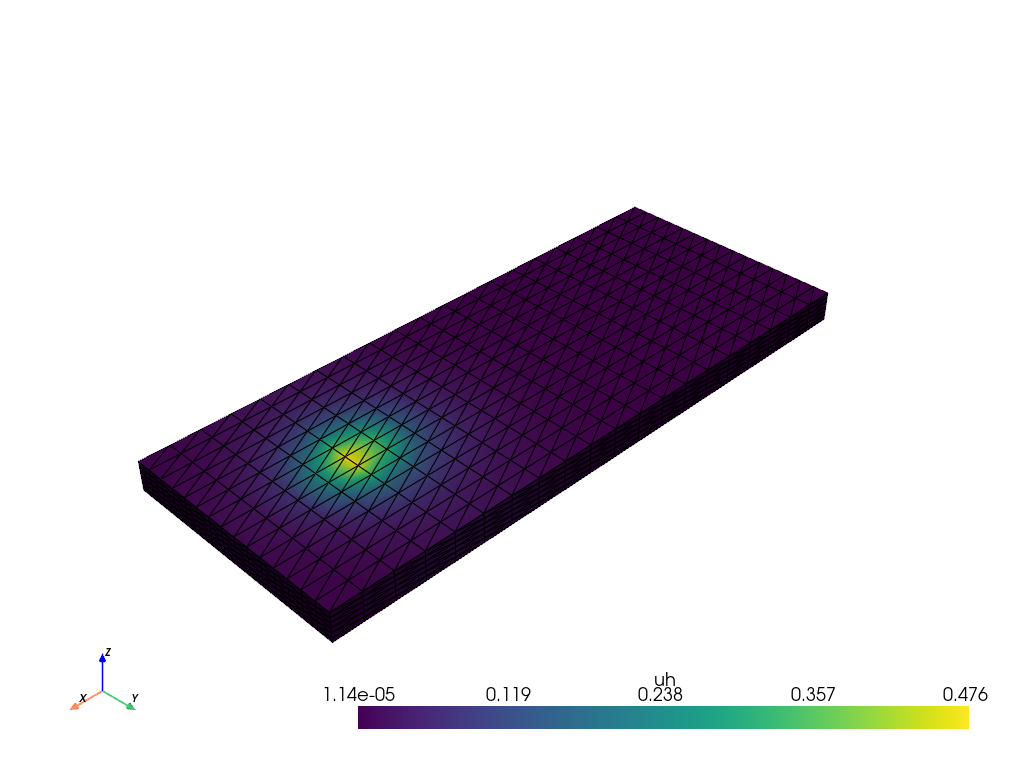

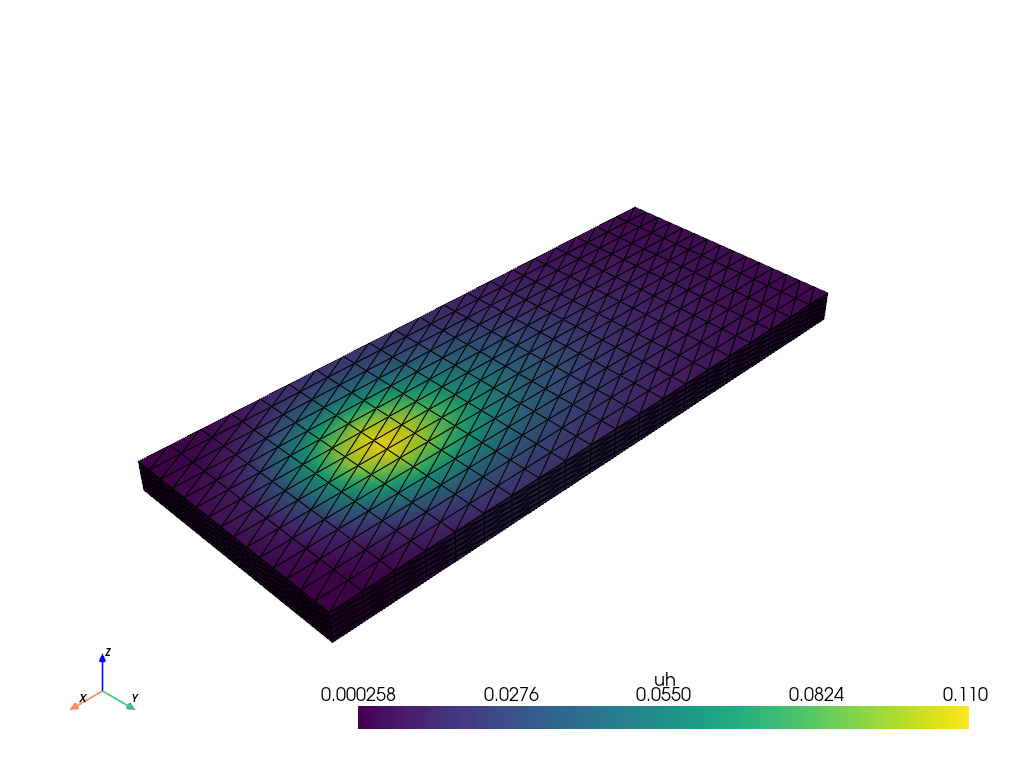

... done sampling
sampler_train.X [[ 1.     0.15 ]
 [10.     0.375]]
adding as new
Start computing 1 samples in parametric dimension 2


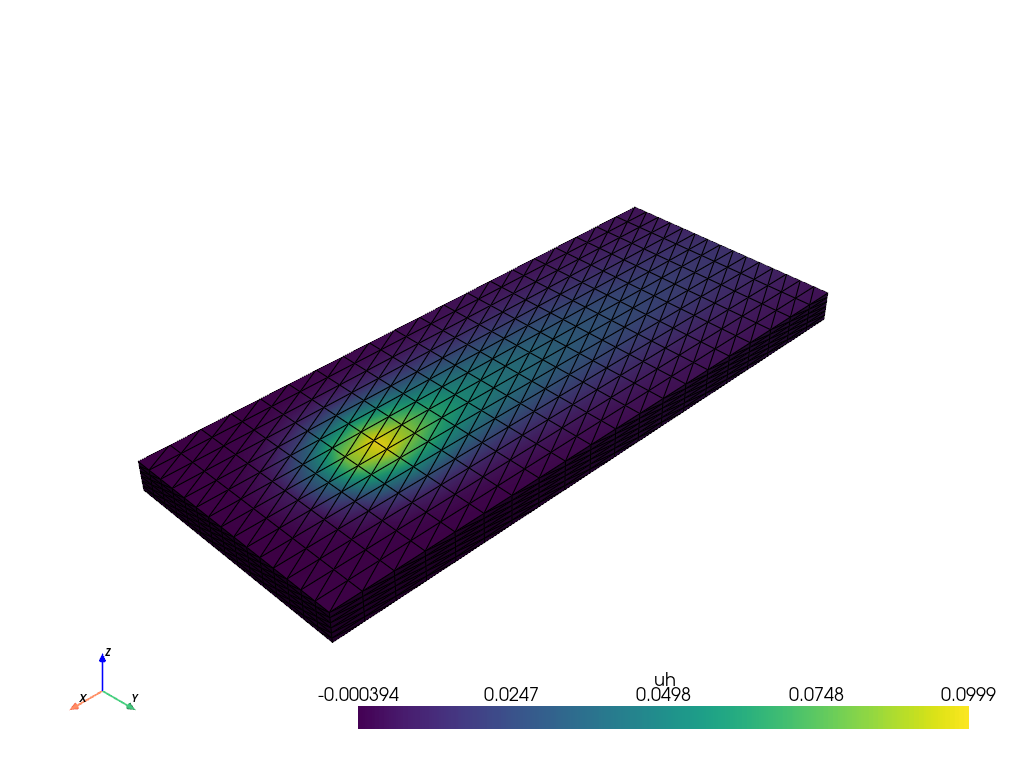

... done sampling
sampler_train.X [[ 1.         0.15     ]
 [10.         0.375    ]
 [31.6227766  0.2625   ]]


In [118]:
parameters = parameters_init.copy()
solver = heat_solver(parameters)
solver.build_mesh()

dimensions = ['heat_source_velocity','width_gaussian']
#types = ['log_normal','log_normal']
#params = [[np.log(10.), 1.],[np.log(0.2) , 1.]]
#types = ['uniform','uniform']
#params = [[1., 100.],[0.1 , 1.]]
types = ['log_uniform','uniform']
params = [[np.log(1), np.log(100.)],[0.15,0.6]]

def compute_QoI(params):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    out = solver.extract_melt_pool_depth()
    return np.array(out).reshape((1,-1))

plot_solution = lambda: solver.plot_solution_pyvista()

sampler_train = sampler_cls(types,params,dimensions,compute_QoI,plot_solution)

sampler_train.sampling(2, DOE_type="QRS" , plot=True)
print("sampler_train.X",sampler_train.X)
sampler_train.sampling(1, DOE_type="QRS" , as_additional_points=True, plot=True)
print("sampler_train.X",sampler_train.X)

# **Meta-modelling**

## Sampling test points

Initiating FEA solver
Meshing
Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
parameter dimension 1 : power
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.25, 1.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0]]
n_out : 1
... done building
Instantiating  PRS  sampler
Start computing 30 samples in parametric dimension 2
... done sampling


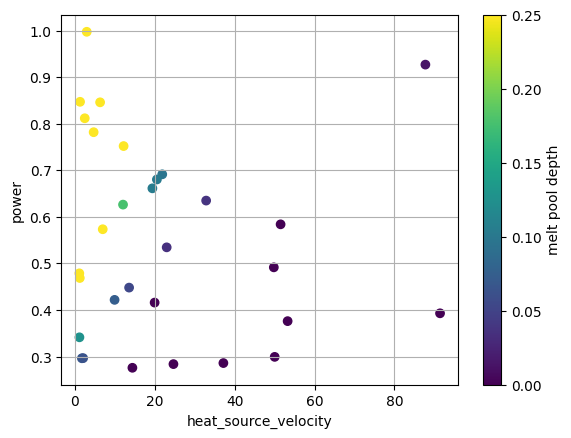

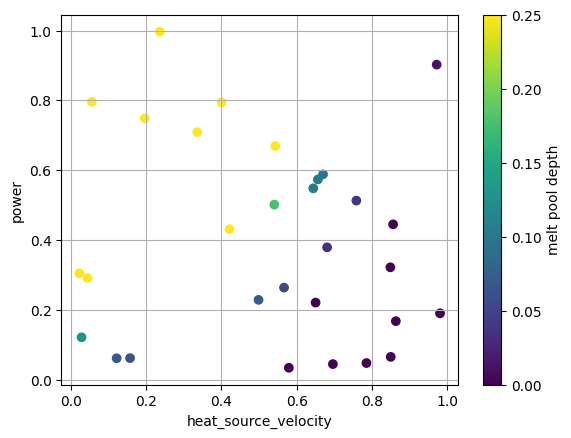

In [166]:
N_samples_test = 30

parameters = parameters_init.copy()
solver = heat_solver(parameters)
solver.build_mesh()

dimensions = ['heat_source_velocity','power']
types = ['log_uniform','uniform']
params = [[np.log(1), np.log(100.)],[0.25 , 1.]]

def compute_QoI(params):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    out = solver.extract_melt_pool_depth()
    return np.array(out).reshape((1,-1))

sampler_test = sampler_cls(types,params,dimensions,compute_QoI)
sampler_test.sampling(N_samples_test)

sampler_test.plot_scatter(clabel='melt pool depth')
sampler_test.plot_scatter(normalised=True,clabel='melt pool depth')

## Base class for all meta_models

In [120]:
class metamodel:
    def __init__(self):
        self.dim = None
        self.n_out = None

    def train_init(self,X,y):

        if X is None:
            print("error : no training data X provided")
        if y is None:
            print("error : no training data y provided")
        if X is not None:
            self.X = X
            self.dim = X.shape[1]
        if y is not None:
            self.y = y
            self.n_out = y.shape[1]

    def train():
        print("not implemented")

    def predict():
        print("not implemented")

    def test(self,X_test=None,y_test=None):

        if self.X is None or self.y is None:
            print("error : training not done so far")
        if X_test is None:
            print("error : no test dataset X_test provided")
        if y_test is None:
            print("error : no test dataset y_test provided")

        else:
            self.X_test = X_test
            self.y_test = y_test

            from sklearn.metrics import r2_score

            y_train = self.y
            y_train_pred = self.predict(self.X)
            print('R2 score train set :',r2_score(y_train, y_train_pred))

            y_test = self.y_test
            y_test_pred = self.predict(self.X_test)
            print('R2 score test set :',r2_score(y_test, y_test_pred))


## Helper functions for polynomial regressors

In [121]:
import itertools

def generate_multi_index(D, N):
    """
    Generate a multi-index for dimension D such that the sum of the indices is less than N.

    Args:
        D (int): The number of dimensions.
        N (int): The maximum sum of indices.

    Returns:
        list of tuples: A list of tuples representing the multi-index.
    """
    # Generate all possible combinations of indices in the range [0, N)
    ranges = [range(N+1) for _ in range(D)]

    # Filter combinations where the sum of indices is less than N
    multiindex = [index for index in itertools.product(*ranges) if sum(index) <= N]

    return multiindex

In [122]:
def monomials(x,order):
  return x**order

# Legendre polynomial https://en.wikipedia.org/wiki/Legendre_polynomials
def Legendre(x,order):
    if order==0:
        return 0.*x + 1. # P0 = 1
    elif order==1:
        return x # P1 = x
    else:
        return (((2 * order)-1)*x * Legendre(x, order-1)-(order-1)*Legendre(x, order-2))/float(order)

def Legendre(x, order): # non recursive implementation generated by chat GPT
    x = np.asarray(x)  # Ensure x is a NumPy array for vectorization

    if order == 0:
        return np.ones_like(x)  # P0 = 1
    elif order == 1:
        return x  # P1 = x

    Pn_2 = np.ones_like(x)  # P0
    Pn_1 = x  # P1

    for n in range(2, order + 1):
        Pn = ((2 * n - 1) * x * Pn_1 - (n - 1) * Pn_2) / n
        Pn_2, Pn_1 = Pn_1, Pn  # Shift values for next iteration

    return Pn

def Legendre_zero_one(x,order): # orthogonality over [0 1] as opposed to [-1 1]
    return Legendre(2.*x-1.,order)

In [123]:
def poly_basis_multi_index(x,monomials_1D,MI):
    poly_val = np.ones((len(x),len(MI)))
    for i in range(len(x)):
        xi = x[i,:]
        for j in range(len(MI)):
            orderj = MI[j]
            for k in range(len(orderj)):
                if orderj[k] != 0:
                    poly_val[i,j] *= monomials_1D(xi[k],order=orderj[k])
    return poly_val

def poly_basis_multi_index(x, monomials_1D, MI): # vectorised version generated by chat GPT
    x = np.asarray(x)
    poly_val = np.ones((len(x),len(MI)))
    for j, orderj in enumerate(MI):
        mask = np.array(orderj) != 0  # Find nonzero orders
        if np.any(mask):  # If at least one feature has a nonzero order
            powers = np.array(orderj)[mask]  # Get nonzero orders
            x_selected = x[:, mask]  # Select relevant features
            monomial_values = np.array([monomials_1D(x_selected[:, k], order=powers[k])
                                        for k in range(len(powers))]).T
            poly_val[:, j] = np.prod(monomial_values, axis=1)
    return poly_val

## Polynomial regression class

In [167]:
class polynomial_regressor(metamodel):

    def __init__(self,order,basis_generator,coeff_reg,SG):
        super().__init__()

        self.order = order
        self.basis_generator = basis_generator
        self.coeff_reg = coeff_reg
        if basis_generator == None:
            self.basis_generator = monomials
        if coeff_reg == None:
            self.coeff_reg = 1.e-10

        self.SG = SG

    def train_init(self,X=None,y=None):
        super().train_init(X,y)

        if self.SG == True:
            self.MI = generate_list_orders_dim(self.dim,self.order)
        else:
            self.MI = generate_multi_index(self.dim, self.order)
        A = poly_basis_multi_index(X,self.basis_generator,self.MI)
        return A

    def predict(self,X):
        A = poly_basis_multi_index(X,self.basis_generator,self.MI)
        return  A @ self.weights

class polynomial_lasso_regressor(polynomial_regressor):
    def __init__(self,order=2,basis_generator=None,coeff_reg=None,SG=False):
        super().__init__(order,basis_generator,coeff_reg,SG)

    def train(self,X=None,y=None):
        A = super().train_init(X,y)

        import sklearn
        model = sklearn.linear_model.Lasso(alpha=self.coeff_reg,fit_intercept=False,max_iter=100000)

        model.fit(A,y)
        self.weights = model.coef_.T
        #self.bias = model.intercept_

class polynomial_ridge_regressor(polynomial_regressor):
    def __init__(self,order=2,basis_generator=None,coeff_reg=None,SG=False):
        super().__init__(order,basis_generator,coeff_reg,SG)

    def train(self,X=None,y=None):
        # matrix whose ith line correpsond to the evaluation of the shape functions at the ith point, called Phi in lecture notes
        A = super().train_init(X,y)

        # ------ this is wrong , to be modified -----------
        self.weights = np.linalg.inv(A.T @ A + self.coeff_reg * np.eye(A.shape[1])) @ A.T @ y
        # -------------------------------------------------

## Standard and sparse polynomial regression

**Exercise 0 :** try increasing the order of the sparse grid to 5 levels (modify sampling accordingly). Does it improve accuracy? At what cost? Does lasso regularisation help?

**Exercise 1 :** implement the polynomial ridge regression correctly, using random or quasi-random sampling instead of sparse grids.

 **Exercise 2 :** Can you regularise the polynomial regression model by choosing the polynomial order wisely? No regularisation

**Answer :** See code above

**Exercise 3 :** (i) Suggest an algorithm to choose the lasso coefficient correctly in sparse polynomial regression, for a given dataset, then (ii) suggest an adaptive algorithm to automatically select the lasso coefficient together with the size of the dataset

**Answer :** Draw $N$ samples, choose regularisation coeff that maximises R2 over the test set. This can done by taking it too large and decreasing it progresssively until the test measure of accuracy increases. If this metric is not large enough, draw $2N$ additional samples. Repeat

Sampler

In [168]:
sampler_train = sampler_cls(types,params,dimensions,compute_QoI)

Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
parameter dimension 1 : power
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.25, 1.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0]]
n_out : 1
... done building


Run cell below multiple times to add sample points to the current list. To reinitialise sampler, execute the cell above

Instantiating  QRS  sampler
samples.shape (1048576, 2)
Start computing 60 samples in parametric dimension 2
... done sampling
sampler_train.X.shape (60, 2)
sampler_train.Y.shape (60, 1)


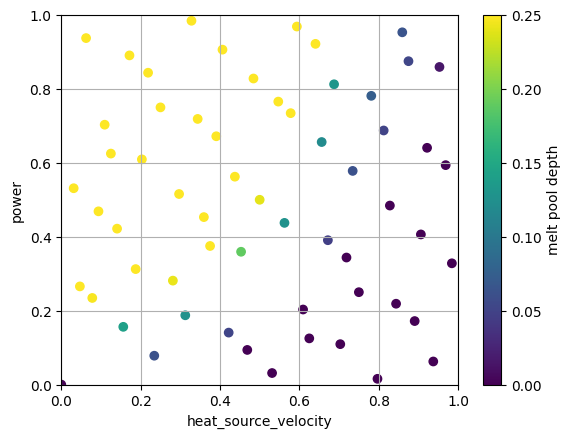

In [169]:
N_samples = 60
sampler_train.sampling(N_samples, DOE_type='QRS', as_additional_points=True)
#sampler_train.sampling(N=4 ,DOE_type='SG', as_additional_points=True)
print("sampler_train.X.shape",sampler_train.X.shape)
print("sampler_train.Y.shape",sampler_train.Y.shape)

#sampler_train_tmp.plot_scatter(normalised=True,clabel='melt pool depth')
prediction_plot(sampler_train.X_normalised,sampler_train.Y,xlim=(0,1),ylim=(0,1),clabel='melt pool depth',
                xlabel=dimensions[0],ylabel=dimensions[1])

#prediction_plot(sampler_train.X,sampler_train.Y,clabel='melt pool depth',
#                xlabel=dimensions[0],ylabel=dimensions[1])

In [182]:
type_regressor = 'lasso'
coeff_reg = 1.0e-4

if type_regressor == 'ridge':
    model = polynomial_ridge_regressor(order=8,basis_generator=Legendre_zero_one,coeff_reg=coeff_reg)
elif type_regressor == 'lasso':
    model = polynomial_lasso_regressor(order=8,basis_generator=Legendre_zero_one,coeff_reg=coeff_reg)
    # Careful, order below is the order of the sparse grid, i.e. number of refinement levels , not the polynomial order
    #model = polynomial_lasso_regressor(order=4,basis_generator=Legendre_zero_one,coeff_reg=coeff_reg,SG=True)
else:
    print("error : unknown meta model type")

model.train(sampler_train.X_normalised,sampler_train.Y)

print("model.MI",model.MI)
print("model.weights",model.weights.T)
print("model.weight.shape",model.weights.shape)
print("sampler_train.X_normalised.shape",sampler_train.X_normalised.shape)

model.MI [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, 0), (5, 1), (5, 2), (5, 3), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (8, 0)]
model.weights [ 1.37727194e-01  8.77070408e-02 -3.96502183e-02  1.06618479e-02
  0.00000000e+00 -1.46192801e-02  7.81870305e-05 -0.00000000e+00
 -1.85967847e-02 -1.42222976e-01 -2.22325137e-02  6.57804984e-02
 -4.39211722e-02 -1.12362871e-02  1.11548476e-02 -2.61978227e-02
 -0.00000000e+00 -3.70663124e-02 -1.00673665e-01  1.75120955e-02
  2.92160290e-03 -3.59802338e-02  0.00000000e+00 -0.00000000e+00
  2.19126993e-02 -2.75921176e-02 -7.18342753e-02  1.87427123e-02
  0.00000000e+00 -1.94131674e-02  2.80406682e-02  3.41914366e-02
 -3.50180550e-02 -2.38591663e-02  0.00000000e+00 -2.04602094e-03
  7.49603542e-04  4.48566885e-0

Compute the coefficient of determination for the training and test sets and plot interpolation results

R2 score train set : 0.9916486194316841
R2 score test set : 0.971523608657561


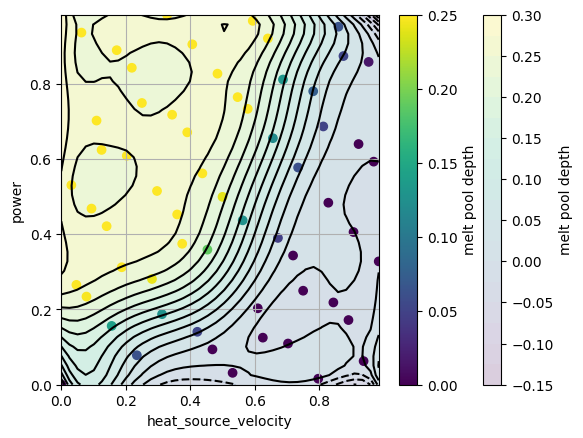

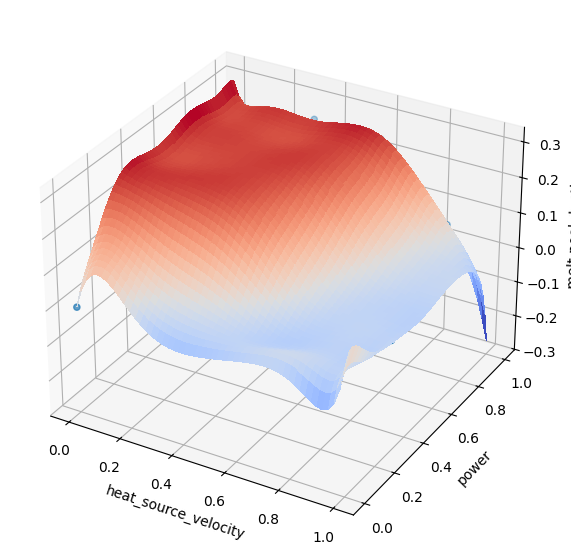

In [183]:
from sklearn.metrics import r2_score
model.test(sampler_test.X_normalised,sampler_test.Y)

model_predict = lambda X: model.predict(X)
prediction_plot(sampler_train.X_normalised,sampler_train.Y,function=model_predict,clabel='melt pool depth',xlabel=dimensions[0],ylabel=dimensions[1])
#prediction_plot(sampler_train.X_normalised,x_plot=np.linspace(0,1,20),y_plot=np.linspace(0,1,20),
#                function=model_predict,xlim=(0,1),ylim=(0,1),xlabel=dimensions[0],ylabel=dimensions[1],
#                clabel='melt pool depth')
#prediction_plot(x_plot=np.linspace(0,1,20),y_plot=np.linspace(0,1,20),
#                function=model_predict,xlim=(0,1),ylim=(0,1),xlabel=dimensions[0],ylabel=dimensions[1],clabel='melt pool depth')

surf_plot(function=model_predict,x_plot=np.linspace(0,1,50), y_plot=np.linspace(0,1,50),X=sampler_train.X_normalised,Y=sampler_train.Y,xlabel=dimensions[0],ylabel=dimensions[1],zlabel='melt pool depth')


## Gaussian Process regression

**Exercise 4 :** what is the regularisation in a GP regression? Force the GP to overfit by choosing a non-optimal prior

**Answer :** set `length_scale_bounds=(1e-2, 1e2)` to `length_scale_bounds=(1e-2, 1e-1)` below to force the length-scale parameter in the covariance kernel to small, i.e.promote oscillatory behaviour

In [129]:
sampler_train = sampler_cls(types,params,dimensions,compute_QoI)

Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
parameter dimension 1 : power
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.25, 1.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0]]
n_out : 1
... done building


In [130]:
sampler_train.sampling(30, DOE_type='QRS', as_additional_points=True)
print("sampler_train.X.shape",sampler_train.X.shape)

Instantiating  QRS  sampler
samples.shape (1048576, 2)
Start computing 30 samples in parametric dimension 2
... done sampling
sampler_train.X.shape (30, 2)


In [131]:
class GP_regressor(metamodel):

    def __init__(self):
        super().__init__()

        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, WhiteKernel

        self.kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e-3))
        self.model = GaussianProcessRegressor(kernel=self.kernel, random_state=10)

    def train(self,X,y):
        super().train_init(X,y)
        self.model.fit(X, y)
        print("optimised kernel parameters",self.model.kernel_)

    def predict(self,X, return_std=False):
        return self.model.predict(X, return_std)


model = GP_regressor()
model.train(sampler_train.X_normalised,sampler_train.Y)


optimised kernel parameters 0.139**2 * RBF(length_scale=0.33) + WhiteKernel(noise_level=0.000196)


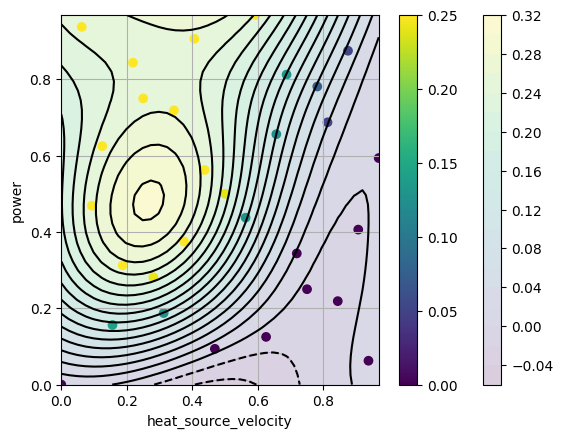

R2 score train set : 0.9925273413668683
R2 score test set : 0.9285301768910831


In [132]:
model_predict = lambda X: model.predict(X)
#prediction_plot(sampler_train.X_normalised,sampler_train.Y,xlim=(0,1),ylim=(0,1))
#prediction_plot(sampler_train.X_normalised,x_plot=np.linspace(0,1,100),y_plot=np.linspace(0,1,100),function=model_predict,xlim=(0,1),ylim=(0,1))
prediction_plot(sampler_train.X_normalised,sampler_train.Y,function=model_predict,xlabel=dimensions[0],ylabel=dimensions[1])

model.test(sampler_test.X_normalised,sampler_test.Y)

## Neural Net regression

**Exercise 5 :** something went awfully wrong with this Neural Network. Repair it.

In [133]:
sampler_train = sampler_cls(types,params,dimensions,compute_QoI)

Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
parameter dimension 1 : power
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.25, 1.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0]]
n_out : 1
... done building


In [134]:
sampler_train.sampling(30, DOE_type='QRS', as_additional_points=True)
print("sampler_train.X.shape",sampler_train.X.shape)

Instantiating  QRS  sampler
samples.shape (1048576, 2)
Start computing 30 samples in parametric dimension 2
... done sampling
sampler_train.X.shape (30, 2)


In [185]:
def plot_during_training(i,X,y_pred,predict):
    if i==1 or int(i) % 100 == 0 and i<1000:
        plot_first = lambda x: predict(x)[:,0]
        prediction_plot(X=X.detach().numpy(),y=y_pred.detach().numpy()[:,0],function=plot_first)

class neural_net_regressor(metamodel):

    def __init__(self,n_hidden=100,X=None,y=None):
        super().__init__()

        self.model=None
        self.n_hidden = n_hidden

    def train(self,X,y,lr=1.e-2,plot_func=None,restart=False):
        super().train_init(X,y)

        import torch
        class mlp(torch.nn.Module):
            def __init__(self,N_in,N_hidden,N_out):
                super().__init__()
                self.linear_in = torch.nn.Linear(N_in, N_hidden)
                self.activation = torch.nn.Sigmoid()
                self.linear_out = torch.nn.Linear(N_hidden, N_out)
                self.inout = torch.nn.Linear(N_in, N_out)

            def forward(self, x):
                out = self.linear_in(x)
                out = self.activation(out)
                out = self.linear_out(out)
                return out

        if (self.model is None) or restart==False:
            self.model = mlp(N_in=self.dim,N_hidden=self.n_hidden,N_out=self.n_out)

        X = torch.from_numpy(X).float().requires_grad_(False)
        y = torch.from_numpy(y).float().requires_grad_(False)

        params = self.model.parameters()
        optimizer = torch.optim.Adam(params,lr=lr)

        for i in range(1,10000):
            y_pred = self.model.forward(X)
            loss = torch.nn.MSELoss()(y.squeeze(),y_pred.squeeze())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if plot_func is not None:
                plot_func(i,X,y_pred,self.predict)

    def predict(self,X):
        import torch
        return self.model.forward(torch.from_numpy(X).float()).detach().numpy()

In [ ]:
model = neural_net_regressor(n_hidden=100)

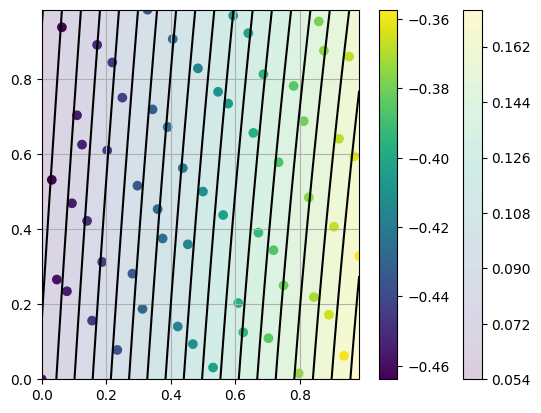

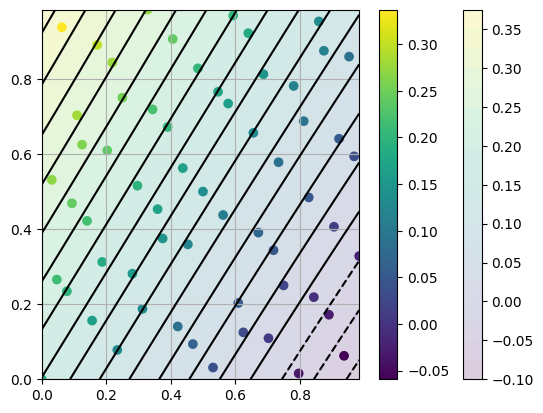

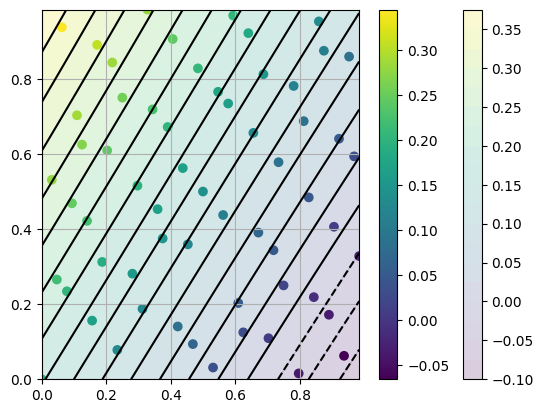

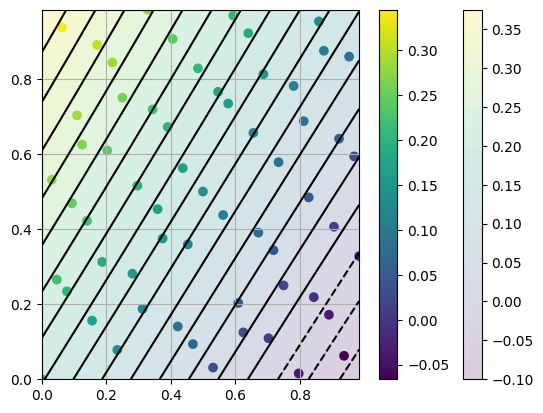

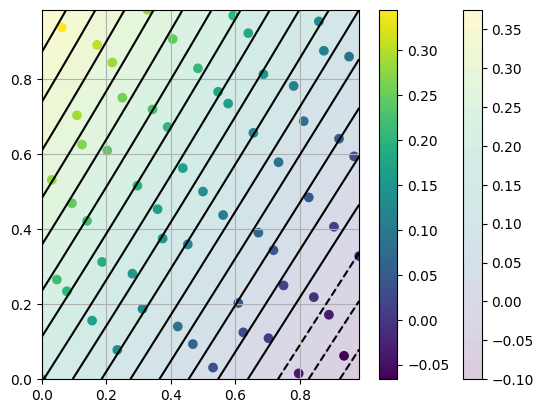

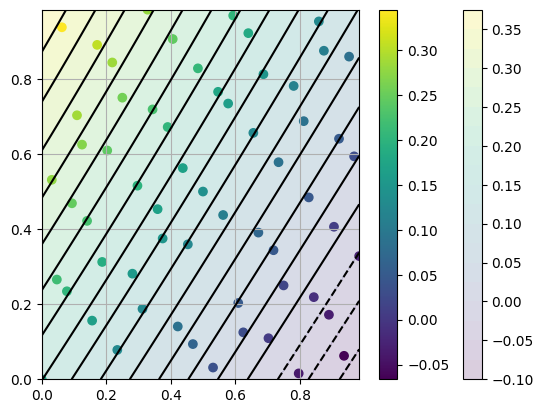

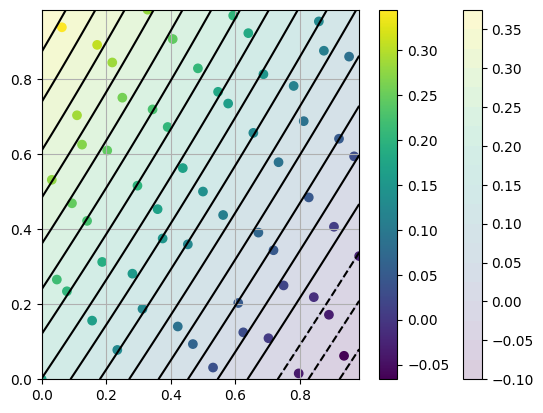

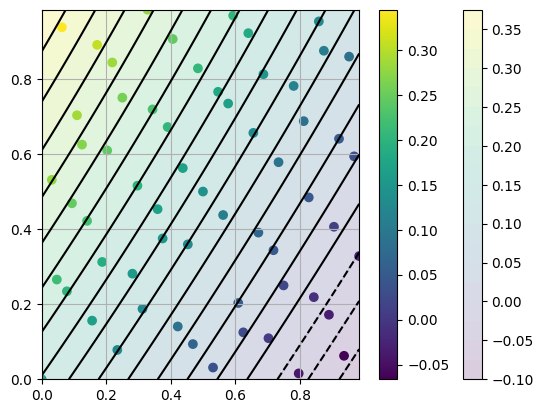

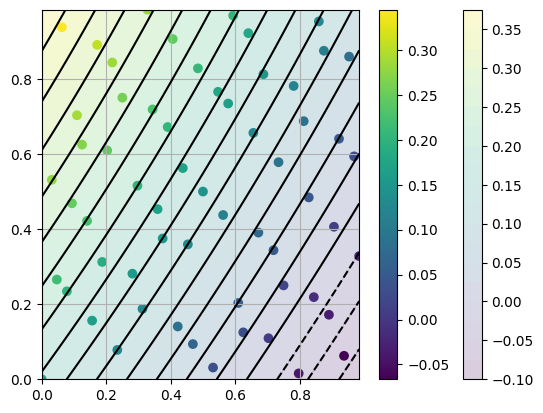

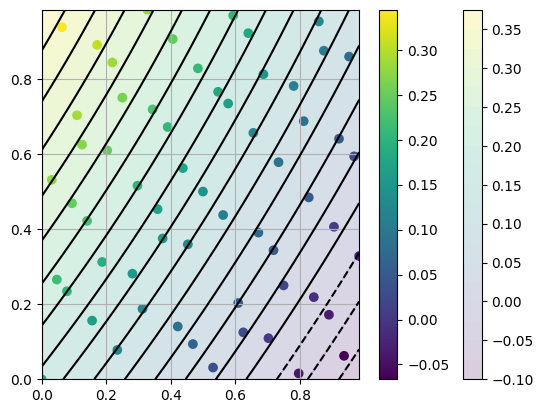

In [186]:
model.train(sampler_train.X_normalised,sampler_train.Y,plot_func=plot_during_training)

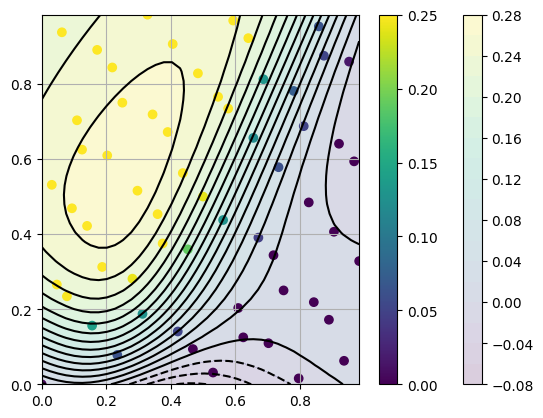

R2 score train set : 0.9734007193143862
R2 score test set : 0.9786940859693132


In [187]:
model_predict = lambda X: model.predict(X)
prediction_plot(sampler_train.X_normalised,sampler_train.Y,function=model_predict)

model.test(sampler_test.X_normalised,sampler_test.Y)

## Nearest neighbour regression

In [138]:
sampler_train = sampler_cls(types,params,dimensions,compute_QoI_pool)

Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
parameter dimension 1 : power
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.25, 1.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0]]
n_out : 1
... done building


In [139]:
sampler_train.sampling(30, DOE_type='QRS', as_additional_points=True)
print("sampler_train.X.shape",sampler_train.X.shape)

Instantiating  QRS  sampler
samples.shape (1048576, 2)
Start computing 30 samples in parametric dimension 2
... done sampling
sampler_train.X.shape (30, 2)


In [140]:
class NNeigh_regressor(metamodel):

    def __init__(self,n_neighbors=1,weights='distance'):
        super().__init__()
        # https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

        self.n_neighbors = n_neighbors
        print("KNN regressor with n_neighbors =",self.n_neighbors,' and weight types =',weights)

        from sklearn.neighbors import KNeighborsRegressor
        self.model = KNeighborsRegressor(self.n_neighbors,weights=weights)

    def train(self,X,y):
        super().train_init(X,y)
        self.model.fit(X, y)

    def predict(self,X, return_std=False):
        return self.model.predict(X)


model = NNeigh_regressor(n_neighbors=1,weights='uniform')
model.train(sampler_train.X_normalised,sampler_train.Y)

KNN regressor with n_neighbors = 1  and weight types = uniform


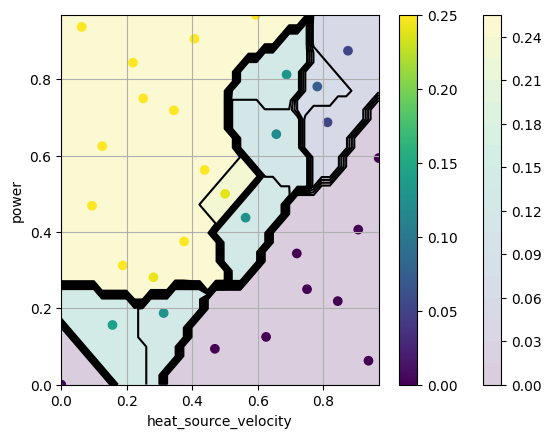

R2 score train set : 1.0
R2 score test set : 0.8042987648599735


In [141]:
model_predict = lambda X: model.predict(X)
prediction_plot(sampler_train.X_normalised,sampler_train.Y,function=model_predict,xlabel=dimensions[0],ylabel=dimensions[1])

model.test(sampler_test.X_normalised,sampler_test.Y)

# Pareto front

In [142]:
parameters = parameters_init.copy()
solver = heat_solver(parameters)
solver.build_mesh()

N_samples_train = 100

dimensions = ['heat_source_velocity','power']
types = ['log_uniform','log_uniform']
params = [[np.log(1), np.log(100.)],[np.log(0.25) , np.log(1.5)]]

def compute_QoI(params):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    #return np.array( solver.extract_melt_pool_depth() ).reshape((1,-1))
    return np.array( [solver.extract_melt_pool_depth() , solver.extract_melt_pool_width() ] ).reshape((1,-1))

sampler_train = sampler_cls(types,params,dimensions,compute_QoI)
sampler_train.sampling(N_samples_train, plot=False)

Initiating FEA solver
Meshing
Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
parameter dimension 1 : power
distribution type for dimension 1 : log_uniform
params of distribution for dimension 1: [-1.3862943611198906, 0.4054651081081644]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0 0]]
n_out : 2
... done building
Instantiating  PRS  sampler
Start computing 100 samples in parametric dimension 2
... done sampling


In [143]:
MM_type = 'sparse_poly'

if MM_type == 'GP':

    model = GP_regressor()
    model.train(sampler_train.X_normalised,sampler_train.Y)

elif MM_type == 'sparse_poly':

    model = polynomial_lasso_regressor(order=8,basis_generator=Legendre,coeff_reg = 1.e-3)
    model.train(sampler_train.X_normalised,sampler_train.Y)

else:
    print("error : unknown meta model type")

model_predict = lambda X: model.predict(X)

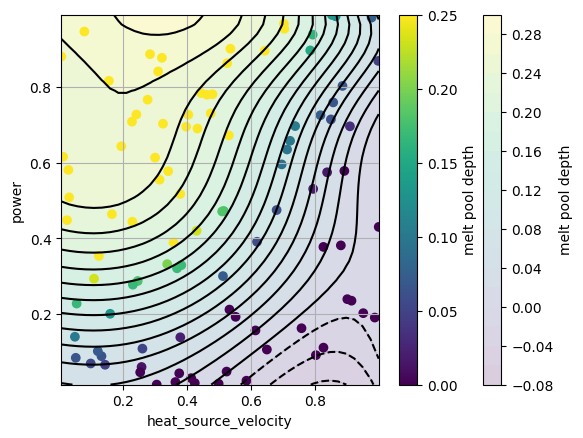

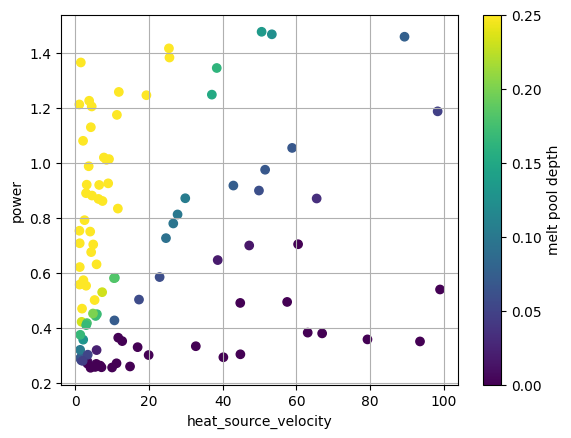

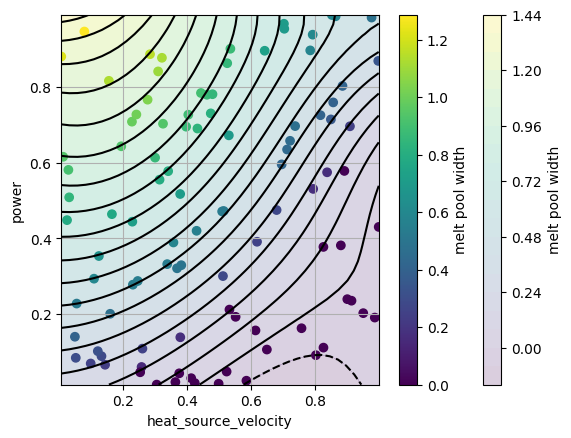

In [144]:
model_predict_0 = lambda X: model_predict(X)[:,0]
prediction_plot(X=sampler_train.X_normalised, y=sampler_train.Y[:,0],
                function=model_predict_0,clabel='melt pool depth',
                xlabel=dimensions[0],ylabel=dimensions[1])

model_predict_0 = lambda X: model_predict(X)[:,0]
prediction_plot(X=sampler_train.X, y=sampler_train.Y[:,0],
                clabel='melt pool depth',
                xlabel=dimensions[0],ylabel=dimensions[1])

model_predict_0 = lambda X: model_predict(X)[:,1]
prediction_plot(X=sampler_train.X_normalised, y=sampler_train.Y[:,1],
                function=model_predict_0,clabel='melt pool width',
                xlabel=dimensions[0],ylabel=dimensions[1])

In [145]:
N_samples_train = 10000

dimensions = ['heat_source_velocity','power']
#types = ['log_uniform','log_uniform']
#params = [[np.log(1), np.log(100.)],[np.log(0.25) , np.log(1.)]]

sampler_tmp = sampler_cls(types,params)
def compute_QoI_MM(X):
    X_normalised = sampler_tmp.normalise(X)
    return model_predict(X_normalised)

sampler_pareto = sampler_cls(types,params,dimensions=None,compute_QoIs=compute_QoI_MM)

sampler_pareto.sampling(N_samples_train, plot=False)

Building your FEA sampler...
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
distribution type for dimension 1 : log_uniform
params of distribution for dimension 1: [-1.3862943611198906, 0.4054651081081644]
n_out : None
... done building
Building your FEA sampler...
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [0.0, 4.605170185988092]
distribution type for dimension 1 : log_uniform
params of distribution for dimension 1: [-1.3862943611198906, 0.4054651081081644]
n_out not provided -> calling FEA solver for automatic determination
n_out : 2
... done building
Instantiating  PRS  sampler
Start computing 10000 samples in parametric dimension 2
... done sampling


sampler.X.shape (10000, 2)
selected_points.shape (5412, 2)


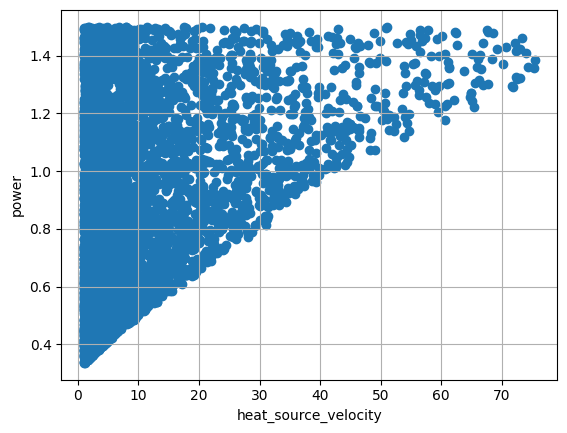

In [146]:
v = sampler_pareto.Y
condition = (v[:,0].reshape(-1,) >= 0.1) & ( v[:,1].reshape(-1,) >= 0.4)
selected_points = sampler_pareto.X[condition]

print("sampler.X.shape",sampler_pareto.X.shape)
print("selected_points.shape",selected_points.shape)

plt.scatter(selected_points[:,0],selected_points[:,1])
plt.xlabel(dimensions[0])
plt.ylabel(dimensions[1])
plt.grid()
plt.show()

# Inverse problem

Initiating FEA solver
Meshing


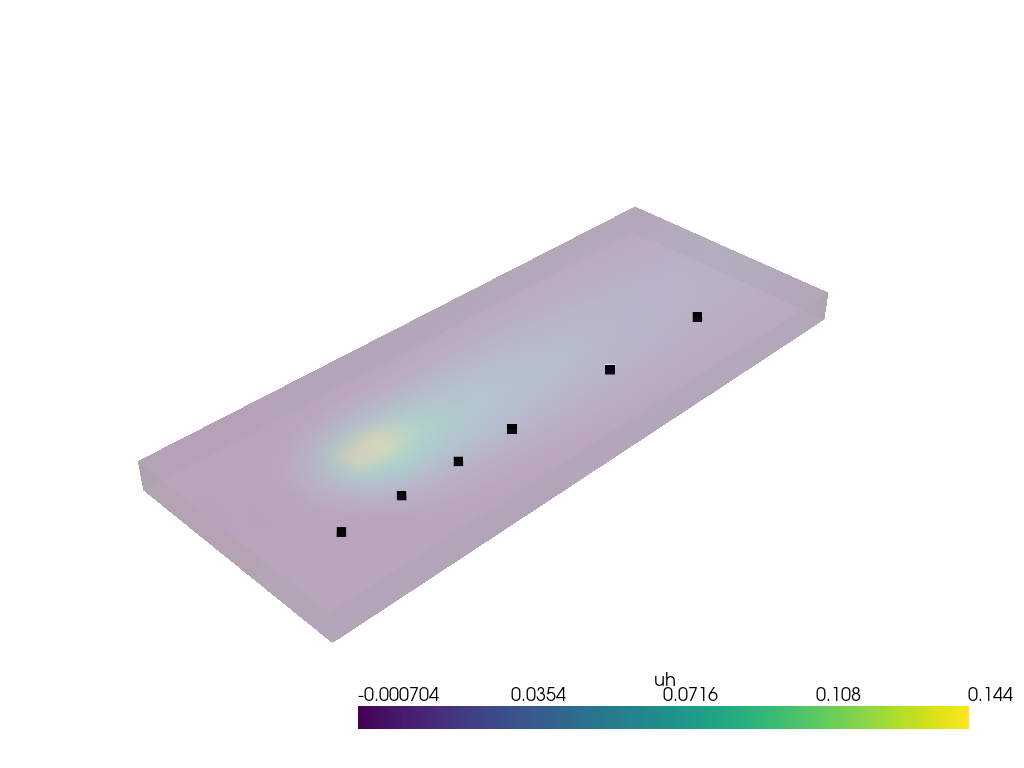

synthetic_data [0.00467989 0.01638814 0.02597324 0.02564889 0.02008299 0.01545696]


In [147]:
parameters = parameters_init.copy()
solver = heat_solver(parameters)
solver.build_mesh()
solver.solve()
#solver.plot_solution_pyvista()

points = np.array([
    [0.5, 0.5, 0.],
    [0., 0.5, 0.],
    [-0.5, 0.5, 0.],
    [-1., 0.5, 0.],
    [-2., 0.5, 0.],
    [-3., 0.5, 0.],
    ])

synthetic_data = solver.extract_temperature_at_points(points,plot=True)
print("synthetic_data",synthetic_data)

def compute_QoI(params):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    out = solver.extract_temperature_at_points(points)
    return np.array(out).reshape((1,-1))

In [148]:
N_samples_train = 100

dimensions = ['width_gaussian','power']
types = ['uniform','uniform']
params = [[0.15, 0.4],[0.5 , 2.]]

sampler_train = sampler_cls(types,params,dimensions,compute_QoI)
sampler_train.sampling(N_samples_train, plot=False)

print("sampler_train.Y.shape",sampler_train.Y.shape)

Building your FEA sampler...
parameter dimension 0 : width_gaussian
distribution type for dimension 0 : uniform
params of distribution for dimension 0: [0.15, 0.4]
parameter dimension 1 : power
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.5, 2.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0.00655777 0.01257836 0.0176151  0.01691933 0.01319755 0.01012182]]
n_out : 6
... done building
Instantiating  PRS  sampler
Start computing 100 samples in parametric dimension 2
... done sampling
sampler_train.Y.shape (100, 6)


In [149]:
MM_type = 'GP'

if MM_type == 'GP':

    model = GP_regressor()
    model.train(sampler_train.X_normalised,sampler_train.Y)

elif MM_type == 'sparse_poly':

    model = polynomial_lasso_regressor(order=8,basis_generator=Legendre,coeff_reg = 1.e-5)
    model.train(sampler_train.X_normalised,sampler_train.Y)

else:
    print("error : unknown meta model type")

model_predict = lambda X: model.predict(X)

  warnings.warn(



optimised kernel parameters 0.58**2 * RBF(length_scale=0.858) + WhiteKernel(noise_level=1e-10)


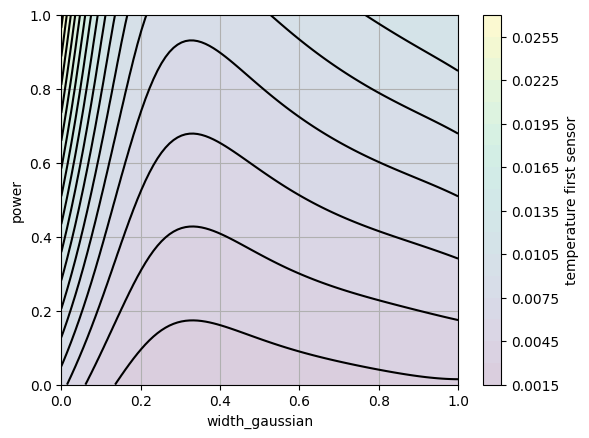

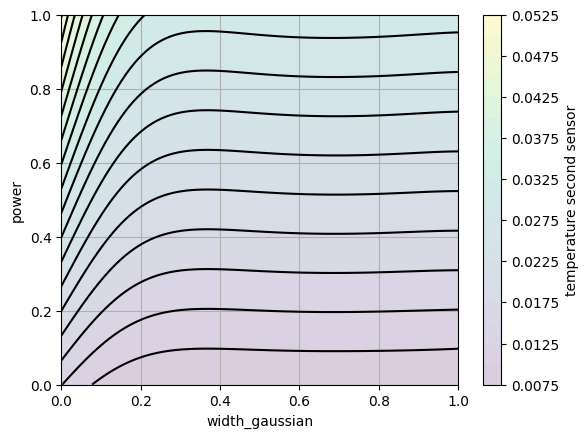

In [150]:
gaussian_process_predict_0 = lambda X: model_predict(X)[:,0]
prediction_plot(x_plot=np.linspace(0,1,100),y_plot=np.linspace(0,1,100),
                function=gaussian_process_predict_0,clabel='temperature first sensor',
                xlabel=dimensions[0],ylabel=dimensions[1])
plt.show()

gaussian_process_predict_1 = lambda X: model_predict(X)[:,1]
prediction_plot(x_plot=np.linspace(0,1,100),y_plot=np.linspace(0,1,100),
                function=gaussian_process_predict_1,clabel='temperature second sensor',
                xlabel=dimensions[0],ylabel=dimensions[1])
plt.show()

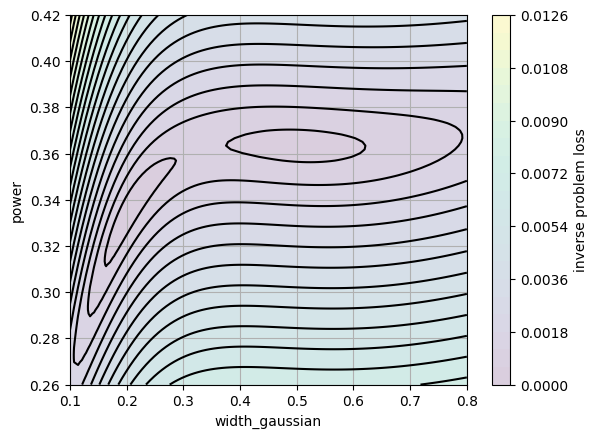

In [151]:
def plotter(X):
    return np.linalg.norm( model_predict(X) - synthetic_data , axis=1)

prediction_plot(x_plot=np.linspace(0.10,0.8,100),y_plot=np.linspace(0.26,0.42,100),
                function=plotter,clabel='inverse problem loss',
                xlabel=dimensions[0],ylabel=dimensions[1])
plt.show()

In [152]:
sampler_tmp = sampler_cls(types,params,dimensions,compute_QoI)

print( "optimal point" , sampler_tmp.denormalise( np.array([0.2,0.34]).reshape((1,-1)) ) )

Building your FEA sampler...
parameter dimension 0 : width_gaussian
distribution type for dimension 0 : uniform
params of distribution for dimension 0: [0.15, 0.4]
parameter dimension 1 : power
distribution type for dimension 1 : uniform
params of distribution for dimension 1: [0.5, 2.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0.00655777 0.01257836 0.0176151  0.01691933 0.01319755 0.01012182]]
n_out : 6
... done building
optimal point [[0.2  1.01]]


Solutions [here](https://colab.research.google.com/drive/1MIZV2RcvWoBEZ468_lT9FMRuYXqa72Av?usp=sharing)

# Additional material

## Sampling in 1D

Initiating FEA solver
Meshing
Building your FEA sampler...
parameter dimension 0 : heat_source_velocity
distribution type for dimension 0 : log_uniform
params of distribution for dimension 0: [2.302585092994046, 5.298317366548036]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point [[0.25]]
n_out : 1
... done building
None
Instantiating  PRS  sampler
Start computing 50 samples in parametric dimension 1
... done sampling


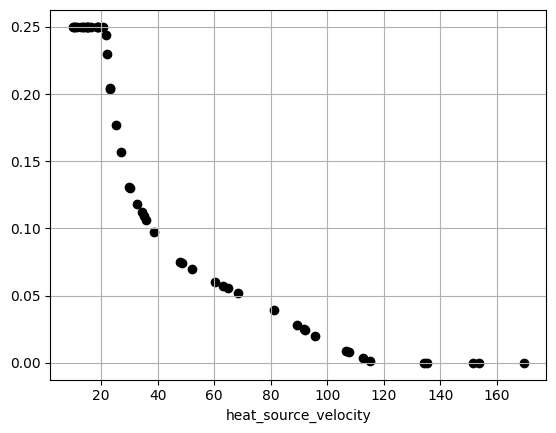

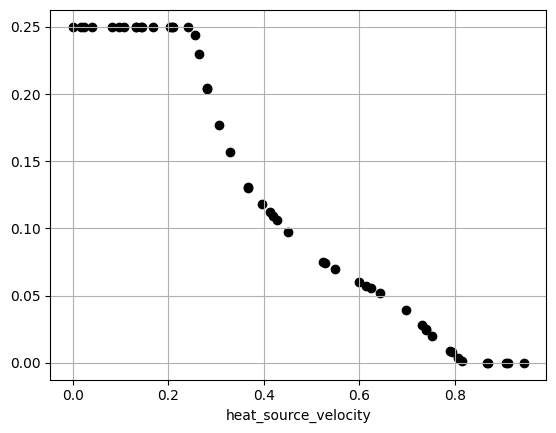

In [153]:
dimensions_1D = ['heat_source_velocity']
types_1D = ['log_uniform']
params_1D = [[np.log(10.), np.log(200.)]]

parameters = parameters_init.copy()
solver = heat_solver(parameters)
solver.build_mesh()

def compute_QoI(params):
    for key, value in params.items():
        solver.parameters[key] = value
    solver.solve()
    out = solver.extract_melt_pool_depth()
    return np.array(out).reshape((1,-1))

sampler_1D = sampler_cls(types_1D,params_1D,dimensions_1D,compute_QoI)
print(sampler_1D.Y)

sampler_1D.sampling(50)
sampler_1D.plot_scatter(clabel='melt pool depth')
sampler_1D.plot_scatter(normalised=True,clabel='melt pool depth')

## NN regression in 1D

prediction [[0.25]
 [0.  ]
 [0.  ]]


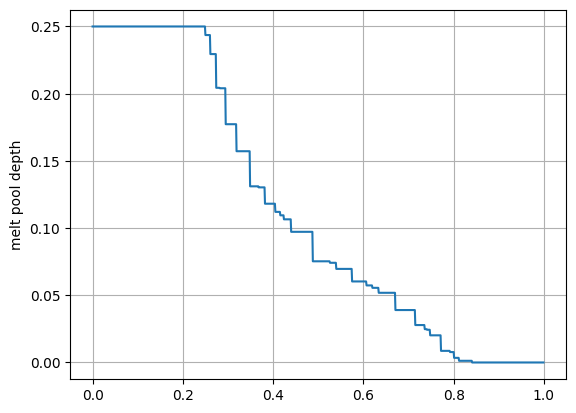

In [154]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(sampler_1D.X_normalised, sampler_1D.Y)

model_predict = lambda X: neigh.predict(X)

prediction = model_predict(np.asarray([0.,1.,10.]).reshape(-1, 1) )
print('prediction',prediction)

prediction_plot(function=model_predict, x_plot = np.arange(0., 1., 0.001), ylabel='melt pool depth' )

## Misc

Instantiating  PRS  sampler


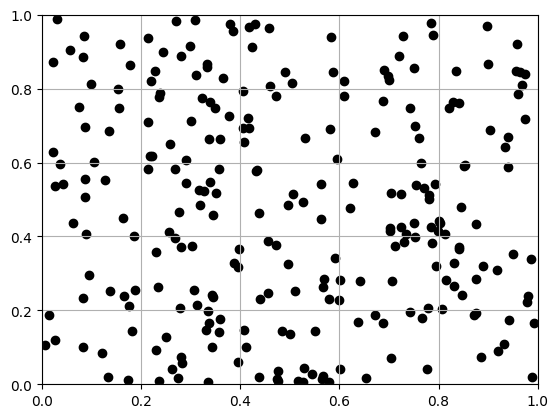

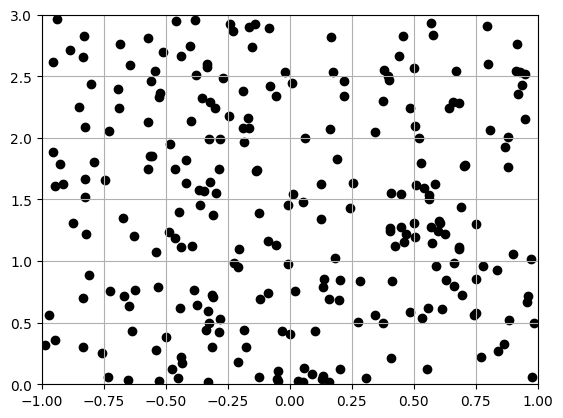

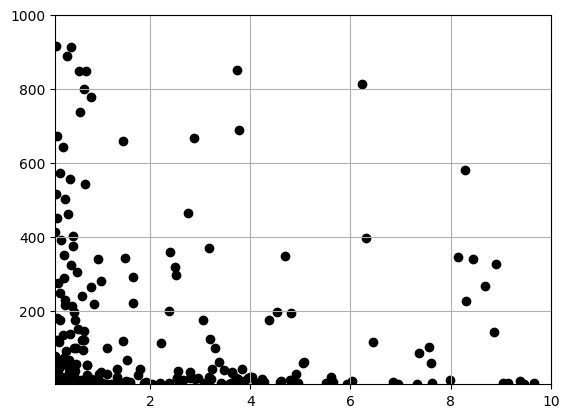

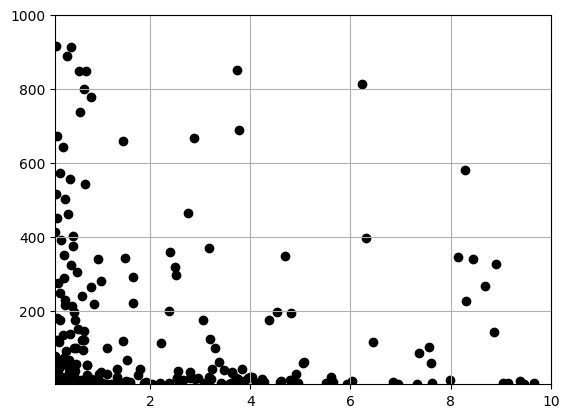

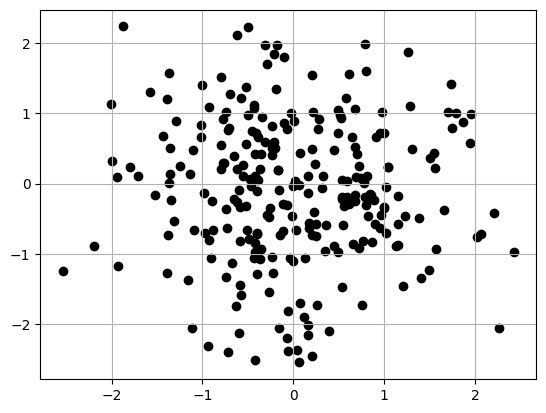

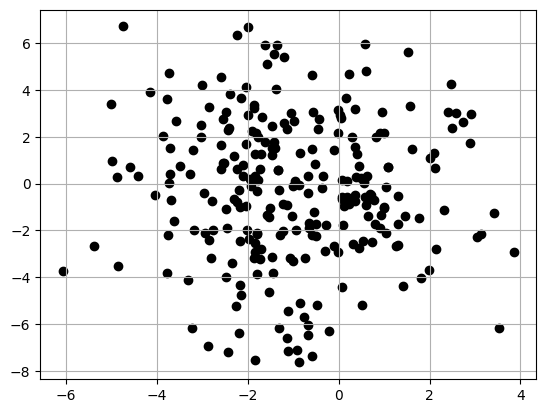

In [155]:
if 1: # plot different sampling transforms
    DOE_plot = DOE_cls(2,DOE_type="PRS")
    DOE_plot.sample(256)

    prediction_plot(DOE_plot.X,xlim=(0,1),ylim=(0,1))

    prediction_plot(X=[2. , 3.]*DOE_plot.X+[-1,0],xlim=(-1,1),ylim=(0,3))

    sequence = (-1, 1)  # This is a tuple
    multiplier = np.log(10)
    # Multiply each element in the sequence by the multiplier
    res1 = tuple(x * multiplier for x in sequence)

    sequence = (0, 3)  # This is a tuple
    multiplier =np.log(10)
    # Multiply each element in the sequence by the multiplier
    res2 = tuple(x * multiplier for x in sequence)

    prediction_plot(np.exp(([2. , 3.]*DOE_plot.X+[-1,0])*np.log(10)),xlim=np.exp(res1),ylim=np.exp(res2) )
    #prediction_plot(DOE_plot.X,xlim=(0,1),ylim=(0,1))

    prediction_plot(np.exp(([2. , 3.]*DOE_plot.X+[-1,0])*np.log(10)),xlim=np.exp(res1),ylim=np.exp(res2) )

    from scipy.stats import norm
    prediction_plot(norm.ppf(DOE_plot.X) )
    prediction_plot([2. , 3.]*norm.ppf(DOE_plot.X)+[-1,0] )

In [156]:
if 0: # to plot shape functions
    def monomial_plot(x):
        return monomials(x[:,0],1) * monomials(x[:,1],2)

    prediction_plot(x_plot=np.linspace(0,1,100),y_plot=np.linspace(0,1,100),function=monomial_plot,xlim=(0,1),ylim=(0,1))

    surf_plot(x_plot=np.linspace(0,1,100),y_plot=np.linspace(0,1,100),function=monomial_plot,xlim=(0,1),ylim=(0,1),xlabel='x1',ylabel='x2')